# State of the Tech Labor Market - Modeling

## Setup

### Import Statements

In [769]:
import pandas as pd
import numpy as np

import string
import re
import datetime
import requests

import yfinance as yf

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pylab import rcParams
import seaborn as sns

from jupyter_dash import JupyterDash as Dash
from dash import html 
from flask import Flask
import plotly.express as px

from statsmodels.tools.sm_exceptions import ConvergenceWarning
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, \
MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import pickle
import zipfile

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore', ConvergenceWarning)

plt.style.use('ggplot')

In [552]:
#conda install -c conda-forge jupyter_contrib_nbextensions

### Data Loading & Cleaning

In [775]:
with zipfile.ZipFile('data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [553]:
total_layoffs_by_month = pd.read_csv('data/monthly_layoffs.csv')
layoffs_raw = pd.read_csv('data/layoffs.csv')
job_postings_national = pd.read_csv('data/job_postings.csv')

In [554]:
# Indeed Job Postings
# url: https://www.hiringlab.org/2022/06/09/data/

indeed_jobs = pd.read_csv('data/Hiring_Lab_subset_country_data_to_2023-01-20_overall.csv')
indeed_sectors = pd.read_csv('data/Hiring_Lab_full_country_data_to_2023-01-20_sector.csv')

In [555]:
# visually inspecting

display(total_layoffs_by_month.head())
display(layoffs_raw.head())
display(job_postings_national.head())

,Unnamed: 0,month,total_laid_off
0,0,2020-03-01,9628.0
1,1,2020-04-01,26710.0
2,2,2020-05-01,25804.0
3,3,2020-06-01,7627.0
4,4,2020-07-01,7112.0


,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Me Poupe,Sao Paulo,Finance,60.0,0.50,2023-01-28,Unknown,Brazil,NaN
1,CoinTracker,SF Bay Area,Crypto,19.0,NaN,2023-01-28,Series A,United States,101.0
2,SSense,Montreal,Retail,138.0,0.07,2023-01-27,Series A,Canada,NaN
3,DealShare,Bengaluru,Retail,100.0,0.06,2023-01-27,Series E,India,390.0
4,Synopsys,SF Bay Area,Other,100.0,NaN,2023-01-27,IPO,United States,NaN


,Unnamed: 0,year,month,day_endofweek,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5,date
0,0,2020,1,10,-0.0407,-0.0748,-0.0399,-0.104,-0.1020,0.00711,0.0629,-0.0013,-0.00683,-0.0723,-0.0646,-0.0512,-0.0889,2020-01-10
1,1,2020,1,17,0.1180,0.0922,0.0660,0.170,0.2240,0.07930,0.0934,0.1120,0.11400,0.1730,0.1260,0.0656,0.2060,2020-01-17
2,2,2020,1,24,-0.0954,-0.0819,-0.1020,-0.117,-0.1520,-0.02490,-0.0591,-0.0570,-0.05680,-0.1170,-0.1150,-0.0985,-0.1640,2020-01-24
3,3,2020,1,31,0.0183,0.0645,0.0758,0.051,0.0292,-0.06150,-0.0973,-0.0538,-0.05010,0.0168,0.0535,0.0841,0.0465,2020-01-31
4,4,2020,2,7,-0.0943,-0.1200,-0.0350,-0.121,-0.0890,-0.09110,-0.0294,-0.0901,-0.09540,-0.1030,-0.1000,-0.0933,-0.1140,2020-02-07


In [556]:
layoffs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2110 non-null   object 
 1   location             2110 non-null   object 
 2   industry             2109 non-null   object 
 3   total_laid_off       1453 non-null   float64
 4   percentage_laid_off  1420 non-null   float64
 5   date                 2110 non-null   object 
 6   stage                2104 non-null   object 
 7   country              2110 non-null   object 
 8   funds_raised         1939 non-null   float64
dtypes: float64(3), object(6)
memory usage: 148.5+ KB


In [557]:
crunchbase = pd.read_csv('data/companies-csv-1-31-2023.csv')
crunchbase2 = pd.read_csv('data/companies-4-csv-1-31-2023.csv')

In [558]:
crunchbase.head()

,Organization Name,Organization Name URL,Industries,Headquarters Location,Description,Website,Founded Date,Founded Date Precision,Industry Groups,Number of Employees,...,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Amount Currency,Last Funding Amount Currency (in USD),Last Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD)
0,Twitter,https://www.crunchbase.com/organization/twitter,"Blogging Platforms, Messaging, SMS, Social Media","San Francisco, California, United States",Twitter is a social networking platform that a...,http://www.twitter.com,2006-03-21,day,"Content and Publishing, Information Technology...",5001-10000,...,15.0,IPO,2022-06-01,NaN,NaN,NaN,Post-IPO Equity,1.286919e+10,USD,1.286919e+10
1,Microsoft,https://www.crunchbase.com/organization/microsoft,"Developer Tools, Enterprise Software, Operatin...","Redmond, Washington, United States",Microsoft is a software corporation that devel...,http://www.microsoft.com,1975-04-04,day,"Platforms, Software",10001+,...,3.0,IPO,2022-11-30,5.000000e+06,USD,5.000000e+06,Private Equity,6.000000e+06,USD,6.000000e+06
2,Netflix,https://www.crunchbase.com/organization/netflix,"Digital Entertainment, Media and Entertainment...","Los Gatos, California, United States",Netflix is an online streaming platform that e...,https://www.netflix.com,1997-01-01,day,"Content and Publishing, Media and Entertainmen...",10001+,...,13.0,IPO,2018-05-05,2.666198e+06,USD,2.666198e+06,Post-IPO Debt,1.219077e+11,USD,1.219077e+11
3,ConsenSys,https://www.crunchbase.com/organization/consen...,"Blockchain, Cryptocurrency, FinTech, Mobile, S...","Brooklyn, New York, United States",ConsenSys builds Ethereum blockchain infrastru...,http://www.consensys.net,2014-01-01,year,"Financial Services, Mobile, Other, Payments, S...",501-1000,...,8.0,Late Stage Venture,2022-10-18,1.670000e+06,USD,1.670000e+06,Secondary Market,7.266700e+08,USD,7.266700e+08
4,Amazon,https://www.crunchbase.com/organization/amazon,"Crowdsourcing, Delivery, E-Commerce, Retail","Seattle, Washington, United States","Amazon is an e-commerce website for consumers,...",http://amazon.com,1994-07-05,day,"Administrative Services, Commerce and Shopping...",10001+,...,3.0,IPO,2023-01-03,8.000000e+09,USD,8.000000e+09,Post-IPO Debt,8.108000e+09,USD,8.108000e+09


In [559]:
crunchbase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 56 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Organization Name                                  954 non-null    object 
 1   Organization Name URL                              954 non-null    object 
 2   Industries                                         951 non-null    object 
 3   Headquarters Location                              952 non-null    object 
 4   Description                                        954 non-null    object 
 5   Website                                            953 non-null    object 
 6   Founded Date                                       946 non-null    object 
 7   Founded Date Precision                             946 non-null    object 
 8   Industry Groups                                    951 non-null    object 
 9   Number of 

In [560]:
crunchbase[crunchbase['Organization Name']=='Ada']

,Organization Name,Organization Name URL,Industries,Headquarters Location,Description,Website,Founded Date,Founded Date Precision,Industry Groups,Number of Employees,...,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Amount Currency,Last Funding Amount Currency (in USD),Last Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD)
139,Ada,https://www.crunchbase.com/organization/ada-su...,"Artificial Intelligence, Intelligent Systems, ...","Toronto, Ontario, Canada",Ada is an automated customer experience compan...,https://www.ada.cx/,2016-01-01,year,"Artificial Intelligence, Data and Analytics, S...",101-250,...,7.0,Late Stage Venture,2021-05-07,130000000.0,USD,130000000.0,Series C,190620620.0,USD,190620620.0


In [561]:
cb_all = pd.concat([crunchbase, crunchbase2], ignore_index=True)
cb_all['Organization Name'] = [name.lower().strip() for name in cb_all['Organization Name']] 
#cb_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 56 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Organization Name                                  1168 non-null   object 
 1   Organization Name URL                              1168 non-null   object 
 2   Industries                                         1163 non-null   object 
 3   Headquarters Location                              1166 non-null   object 
 4   Description                                        1168 non-null   object 
 5   Website                                            1167 non-null   object 
 6   Founded Date                                       1158 non-null   object 
 7   Founded Date Precision                             1158 non-null   object 
 8   Industry Groups                                    1163 non-null   object 
 9   Number o

In [562]:
# to help with merging with layoffs_raw dataset
cb_all['Organization Name'][cb_all['Organization Name']=='ada'] = 'ada support'

In [563]:
cb_all[cb_all['Organization Name']=='ada support'] 

,Organization Name,Organization Name URL,Industries,Headquarters Location,Description,Website,Founded Date,Founded Date Precision,Industry Groups,Number of Employees,...,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Amount Currency,Last Funding Amount Currency (in USD),Last Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD)
139,ada support,https://www.crunchbase.com/organization/ada-su...,"Artificial Intelligence, Intelligent Systems, ...","Toronto, Ontario, Canada",Ada is an automated customer experience compan...,https://www.ada.cx/,2016-01-01,year,"Artificial Intelligence, Data and Analytics, S...",101-250,...,7.0,Late Stage Venture,2021-05-07,130000000.0,USD,130000000.0,Series C,190620620.0,USD,190620620.0


In [567]:
#layoffs_raw = layoffs_raw.dropna(subset='industry').reset_index()

In [568]:
layoffs_raw['company'] = [name.lower().strip() for name in 
                          layoffs_raw['company']]
layoffs_all = layoffs_raw.merge(cb_all, left_on='company', 
                                right_on='Organization Name', how='left')
#layoffs_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 0 to 2126
Data columns (total 65 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   company                                            2127 non-null   object 
 1   location                                           2127 non-null   object 
 2   industry                                           2126 non-null   object 
 3   total_laid_off                                     1467 non-null   float64
 4   percentage_laid_off                                1433 non-null   float64
 5   date                                               2127 non-null   object 
 6   stage                                              2121 non-null   object 
 7   country                                            2127 non-null   object 
 8   funds_raised                                       1954 non-null   float64
 9   Organiza

In [569]:
sum(layoffs_raw['company'].duplicated())

393

In [570]:
sum(layoffs_raw.duplicated())

2

In [572]:
# funds raised in first round of layoffs and
# year of first layoffs

layoffs_raw['funds_raised'] = layoffs_raw['funds_raised'].fillna(layoffs_raw['funds_raised'].median())

layoffs_sorted = layoffs_raw[['company', 'funds_raised', 'date']].sort_values(by='date')

ff = layoffs_sorted.drop_duplicates(subset=['company'], keep='first')
ff['year_fr'] = [pd.to_datetime(day).year for day in ff.date]
ff.columns=['company', 'funds_raised_fr', 'date_fr', 'year_fr']

ff[ff.company=='uber']

,company,funds_raised_fr,date_fr,year_fr
1683,uber,24700.0,2020-05-06,2020


In [573]:
len(set(layoffs_all.company[layoffs_all['Organization Name'].isna()]))

601

In [574]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 2109 to 0
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          1717 non-null   object 
 1   funds_raised_fr  1717 non-null   float64
 2   date_fr          1717 non-null   object 
 3   year_fr          1717 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 67.1+ KB


In [577]:
# dropping columns with too many nans

layoffs_fin = layoffs_all.drop(columns=['Aberdeen - Services Spend', 
                                        'Aberdeen - Services Spend Currency', 
                                        'Aberdeen - Services Spend Currency (in USD)', 
                                        'Last Layoff Mention Date', 
                                        'Apptopia - Number of Apps', 
                                        'Apptopia - Downloads Last 30 Days', 
                                        'Stock Symbol', 
                                        'Stock Symbol URL', 
                                        'Aberdeen - IT Spend', 
                                        'Aberdeen - IT Spend Currency', 
                                        'Aberdeen - IT Spend Currency (in USD)', 
                                        'Aberdeen - Software Spend', 
                                        'Aberdeen - Software Spend Currency', 
                                        'Aberdeen - Software Spend Currency (in USD)', 
                                        'Aberdeen - Communications Spend', 
                                        'Aberdeen - Communications Spend Currency', 
                                        'Aberdeen - Communications Spend Currency (in USD)', 
                                        'Organization Name URL', 
                                        'Description', 
                                        'Website', 
                                        'Acquisition Status'], 
                               axis=1)

In [579]:
layoffs_fin = layoffs_fin.dropna(subset = ['Organization Name']).reset_index(drop=True)
layoffs_fin.shape

(1473, 44)

In [581]:
# filling missing values with 0
layoffs_fin['Number of Acquisitions'] = layoffs_fin['Number of Acquisitions'].fillna(0)

In [582]:
set(layoffs_fin['Number of Employees'])

{'1-10',
 '10001+',
 '1001-5000',
 '101-250',
 '11-50',
 '251-500',
 '5001-10000',
 '501-1000',
 '51-100',
 nan}

In [583]:
layoffs_fin = layoffs_fin.dropna(subset = ['Number of Employees', 
                                           'Industries', 
                                           'Industry Groups', 
                                           'Operating Status']).reset_index(drop=True)

In [584]:
employee_count = {'10001+': 10000,
                  '1001-5000': 3000, 
                  '101-250': 175, 
                  '11-50': 30, 
                  '251-500': 375,
                  '51-100': 75,
                  '1-10': 5,
                  '5001-10000': 7500,
                  '501-1000': 750
                 }
layoffs_fin['employee_count_est'] = [employee_count[ct] for ct in layoffs_fin['Number of Employees']]
set(layoffs_fin['employee_count_est'])

{5, 30, 75, 175, 375, 750, 3000, 7500, 10000}

In [585]:
layoffs_fin['percentage_laid_off'][layoffs_fin['percentage_laid_off'].isna()] = \
layoffs_fin['total_laid_off'] / layoffs_fin['employee_count_est']

layoffs_fin['total_laid_off'][layoffs_fin['total_laid_off'].isna()] = \
layoffs_fin['percentage_laid_off'] * layoffs_fin['employee_count_est']

layoffs_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   company                                 1459 non-null   object 
 1   location                                1459 non-null   object 
 2   industry                                1459 non-null   object 
 3   total_laid_off                          1391 non-null   float64
 4   percentage_laid_off                     1391 non-null   float64
 5   date                                    1459 non-null   object 
 6   stage                                   1456 non-null   object 
 7   country                                 1459 non-null   object 
 8   funds_raised                            1366 non-null   float64
 9   Organization Name                       1459 non-null   object 
 10  Industries                              1459 non-null   obje

In [586]:
df_classification_cb = layoffs_fin.merge(ff, on='company', how='left')

In [587]:
df_classification_cb = df_classification_cb[['company',
                                             'date',
                                             'industry',
                                             'country',
                                             'Headquarters Location',
                                             'Headquarters Regions',
                                             'Operating Status',
                                             'total_laid_off', 
                                             'percentage_laid_off', 
                                             'stage',
                                             'Industries', 
                                             'Industry Groups',
                                             'Total Funding Amount Currency (in USD)', 
                                             'Estimated Revenue Range', 
                                             'Number of Funding Rounds', 
                                             'Trend Score (30 Days)',
                                             'Number of Employees', 
                                             'Number of Acquisitions',
                                             'year_fr',
                                             'funds_raised_fr',
                                             'Founded Date'
                                            ]]

In [588]:
df_classification_cb['founded_year'] = [pd.to_datetime(day).year for day 
                                        in df_classification_cb['Founded Date']]

In [589]:
df_classification_cb['Total Funding Amount Currency (in USD)'].\
    fillna(df_classification_cb['Total Funding Amount Currency (in USD)'].median(), 
           inplace=True)

In [590]:
set(df_classification_cb['Estimated Revenue Range'])

{'$100M to $500M',
 '$10B+',
 '$10M to $50M',
 '$1B to $10B',
 '$1M to $10M',
 '$500M to $1B',
 '$50M to $100M',
 'Less than $1M',
 nan}

In [591]:
sum(df_classification_cb['Estimated Revenue Range'].isna())

294

In [592]:
rev_ranges = {
'$100M to $500M': 300000000,
'$10B+': 10000000000,
'$10M to $50M': 30000000,
'$1B to $10B': 5000000000,
'$1M to $10M': 5000000,
'$500M to $1B': 750000000,
'$50M to $100M': 75000000,
'Less than $1M': 500000
}

df_classification_cb['Estimated Revenue Range'].fillna('n/a', inplace=True)

df_classification_cb['rev_est'] = [rev_ranges[rev] if rev!= 'n/a' else np.nan 
                                   for rev in df_classification_cb['Estimated Revenue Range']]

df_classification_cb['rev_est'].fillna(df_classification_cb['rev_est'].median(), 
                                       inplace=True)

In [593]:
df_classification_cb['total_laid_off'].\
fillna(df_classification_cb['total_laid_off'].median(), inplace=True)

df_classification_cb['percentage_laid_off'].\
fillna(df_classification_cb['percentage_laid_off'].median(), inplace=True)

df_classification_cb['Number of Funding Rounds'].\
fillna(df_classification_cb['Number of Funding Rounds'].median(), inplace=True)

In [594]:
df_classification_cb = df_classification_cb.dropna(subset=['Founded Date']).reset_index(drop=True)

In [595]:
df_classification_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   company                                 1456 non-null   object 
 1   date                                    1456 non-null   object 
 2   industry                                1456 non-null   object 
 3   country                                 1456 non-null   object 
 4   Headquarters Location                   1456 non-null   object 
 5   Headquarters Regions                    1334 non-null   object 
 6   Operating Status                        1456 non-null   object 
 7   total_laid_off                          1456 non-null   float64
 8   percentage_laid_off                     1456 non-null   float64
 9   stage                                   1454 non-null   object 
 10  Industries                              1456 non-null   obje

In [596]:
ixn = yf.Ticker("IXN")
hist = ixn.history(period="3y")

In [765]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2020-02-03 00:00:00-05:00,35.208932,35.749001,35.208932,35.706577,640800,0.0,0.0,0.0
2020-02-04 00:00:00-05:00,36.324968,36.698613,36.279284,36.682297,526800,0.0,0.0,0.0
2020-02-05 00:00:00-05:00,37.204412,37.238676,36.662711,36.951508,837600,0.0,0.0,0.0
2020-02-06 00:00:00-05:00,37.046151,37.217472,36.889515,37.181576,497400,0.0,0.0,0.0
2020-02-07 00:00:00-05:00,36.975988,37.065728,36.754083,36.793243,415200,0.0,0.0,0.0


In [598]:
tech_stocks = hist['Close'].reset_index()
#tech_stocks['Date'][0].replace(tzinfo=None)
tech_stocks['Date'] = pd.to_datetime(tech_stocks['Date'].dt.date)

In [599]:
tech_stocks.columns = ['date', 'close_px']
tech_stocks['close_px'] = tech_stocks['close_px'].ffill()

In [600]:
tech_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      757 non-null    datetime64[ns]
 1   close_px  757 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.0 KB


In [601]:
tech_stocks.to_csv('data/IXN_ETF.csv')

## Helper Functions

In [602]:
#Plot rolling statistics
def check_stationarity(df, window, values):
    
    '''
    df includes index
    window is int (representing period of time)
    values are x values in df (1d array)
    '''
    
    moving_avg = df.rolling(window).mean() # 4 week lag
    moving_std = df.rolling(window).std()

    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=45)
    plt.show(block=False)

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(values, autolag='AIC')

    # Extract and display test results
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used',
                                'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
# mean and standard deviation increasing with time = not stationary

In [604]:
''' 
Function to perform train_test_split and necessary preprocessing / scaling
'''

def train_test_preprocess(X, y, cat_columns):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # check that there are the same number of rows in X as values in y
    assert X_train.shape[0] == y_train.shape[0]

    # continuous features
    X_train_cont = X_train.select_dtypes(exclude=['object']).reset_index(drop=True)
    X_test_cont = X_test.select_dtypes(exclude=['object']).reset_index(drop=True)
    
    # categorical featurs
    cat_train = X_train[cat_columns].reset_index(drop=True)
    cat_test = X_test[cat_columns].reset_index(drop=True)

    # Scale continuous variables using Standard Scaler:
    scaler = StandardScaler() # instantiate Standard Scaler

    ## TRAIN
    # Fit and transform X_train
    X_train_cont_scaled = scaler.fit_transform(X_train_cont)
    X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=X_train_cont.columns)

    # One hot encode categoricals
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    encoded_train = ohe.fit_transform(cat_train).toarray()
    X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names(cat_train.columns))

    # Putting it all together:
    X_train_processed = pd.concat([X_train_cat, X_train_cont], axis=1)
    X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled], axis=1) 

    ## TEST
    # Scale continuous features
    X_test_cont_scaled = scaler.transform(X_test_cont)
    X_test_cont_scaled = pd.DataFrame(X_test_cont_scaled, columns=X_test_cont.columns)

    # One hot encoding categoricals
    encoded_test = ohe.transform(cat_test).toarray()
    X_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names(cat_test.columns))

    # Putting it all together
    X_test_scaled = pd.concat([X_test_cat, X_test_cont_scaled], axis=1)
    X_test_processed = pd.concat([X_test_cat, X_test_cont], axis=1)
    
    return X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, y_train, y_test

In [605]:
''' 
Function to print relevant scoring metrics
'''

def print_scores(y_train, y_hat_train, y_test, y_hat_test, binary=True):
    if binary:
        print('Training Recall: ', 
              recall_score(y_train, y_hat_train))
        print('Testing Recall: ', 
              recall_score(y_test, y_hat_test))
        print('\n')
        print('Training F1: ', 
              f1_score(y_train, y_hat_train))
        print('Testing F1: ', 
              f1_score(y_test, y_hat_test))
        print('\n')
        false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_hat_test)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print('ROC AUC: ', roc_auc)
        print('\n')
        
    else:
        print('Training Recall (weighted avg): ', 
              recall_score(y_train, y_hat_train, average='weighted'))
        print('Testing Recall (weighted avg): ', 
              recall_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training Recall (macro avg): ', 
              recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall (macro avg): ', 
              recall_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Training F1-Score (weighted avg): ', 
              f1_score(y_train, y_hat_train, average='weighted'))
        print('Testing F1-Score (weighted avg): ', 
              f1_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training F1-Score (macro avg): ', 
              f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score (macro avg): ', 
              f1_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Testing Recall (failure class): ', 
              recall_score(y_test, y_hat_test, average=None, labels=[1]))
        print('\n')
    
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

# Time Series Forecasting - Job Postings

## Job Postings

In [311]:
job_postings_national.head() # should get rid of first column (extra index)

,Unnamed: 0,year,month,day_endofweek,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5,date
0,0,2020,1,10,-0.0407,-0.0748,-0.0399,-0.104,-0.1020,0.00711,0.0629,-0.0013,-0.00683,-0.0723,-0.0646,-0.0512,-0.0889,2020-01-10
1,1,2020,1,17,0.1180,0.0922,0.0660,0.170,0.2240,0.07930,0.0934,0.1120,0.11400,0.1730,0.1260,0.0656,0.2060,2020-01-17
2,2,2020,1,24,-0.0954,-0.0819,-0.1020,-0.117,-0.1520,-0.02490,-0.0591,-0.0570,-0.05680,-0.1170,-0.1150,-0.0985,-0.1640,2020-01-24
3,3,2020,1,31,0.0183,0.0645,0.0758,0.051,0.0292,-0.06150,-0.0973,-0.0538,-0.05010,0.0168,0.0535,0.0841,0.0465,2020-01-31
4,4,2020,2,7,-0.0943,-0.1200,-0.0350,-0.121,-0.0890,-0.09110,-0.0294,-0.0901,-0.09540,-0.1030,-0.1000,-0.0933,-0.1140,2020-02-07


In [312]:
df = job_postings_national[['date', 'bg_posts']]
df.head()

,date,bg_posts
0,2020-01-10,-0.0407
1,2020-01-17,0.1180
2,2020-01-24,-0.0954
3,2020-01-31,0.0183
4,2020-02-07,-0.0943


In [313]:
df = job_postings_national[['date', 'bg_posts']]

# index needs to be DatetimeIndex named "date"
if isinstance(df.index, pd.DatetimeIndex):
    df.index.name = 'date'
else:
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
# weekly frequency, on Fridays 
#df = df['bg_posts'].resample('W-FRI').mean()
df = df.asfreq('W-FRI')
df.head()

,bg_posts
date,
2020-01-10,-0.0407
2020-01-17,0.1180
2020-01-24,-0.0954
2020-01-31,0.0183
2020-02-07,-0.0943


#### Stationarity Check & Trend Visualization

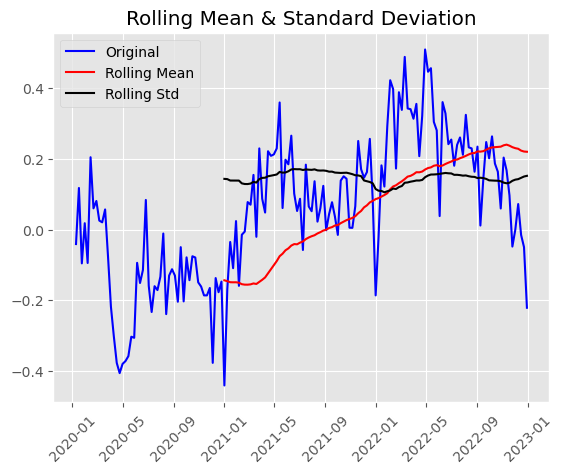

Results of Dickey-Fuller Test:
Test Statistic                  -1.823939
p-value                          0.368643
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [314]:
# dickey fuller test to check stationarity - 52 week window

# the below plot and data does not show stationarity (p value > 0.05, 
# as well as clear upward trend in the rolling mean)

check_stationarity(df, 52, df['bg_posts'])

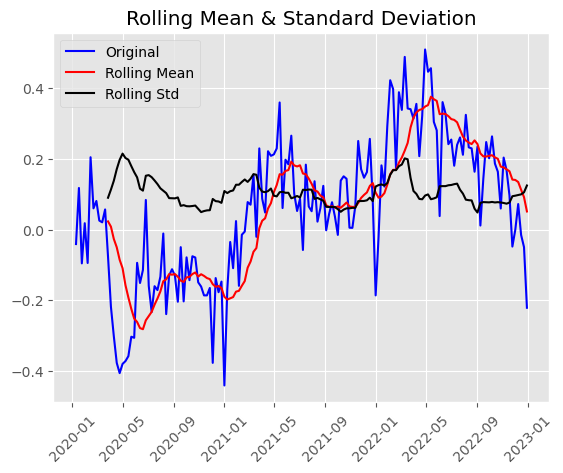

Results of Dickey-Fuller Test:
Test Statistic                  -1.823939
p-value                          0.368643
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [315]:
# dickey Fuller test to check stationarity - 12 week window
check_stationarity(df, 12, df['bg_posts'])

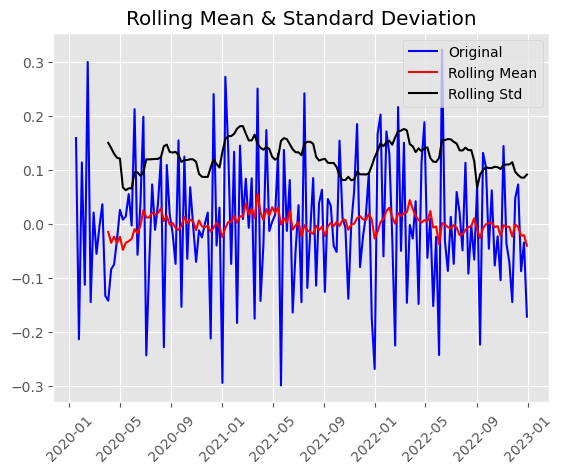

Results of Dickey-Fuller Test:
Test Statistic                -9.817304e+00
p-value                        5.454309e-17
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [316]:
# this looks more stationary, implies one degree of differencing needed
# p value less than 0.05
check_stationarity(df.diff(), 12, df['bg_posts'].diff().dropna())

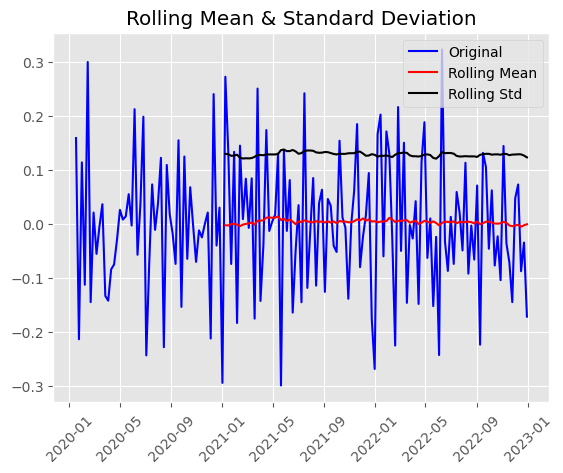

Results of Dickey-Fuller Test:
Test Statistic                -9.817304e+00
p-value                        5.454309e-17
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [317]:
# this is the most stationary, implies one degree of differencing needed
# flat rolling mean and std, differenced data, 52 week period

check_stationarity(df.diff(), 52, df['bg_posts'].diff().dropna())

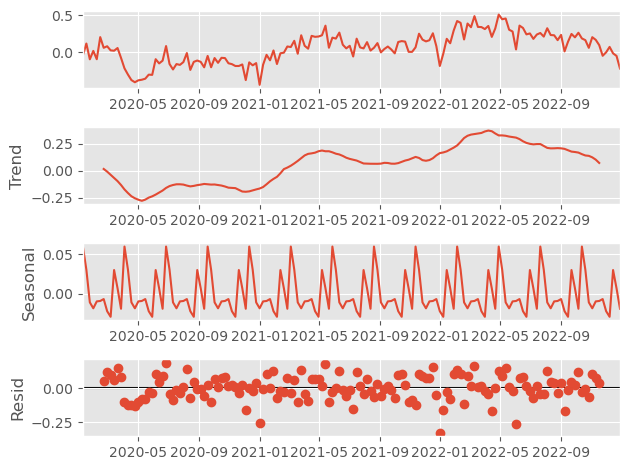

In [318]:
# with 12 period, see clear seasonal pattern and upward trend
# residuals look ok (evenly spread out)

sd = seasonal_decompose(df, period=12)
sd.plot()
plt.show()

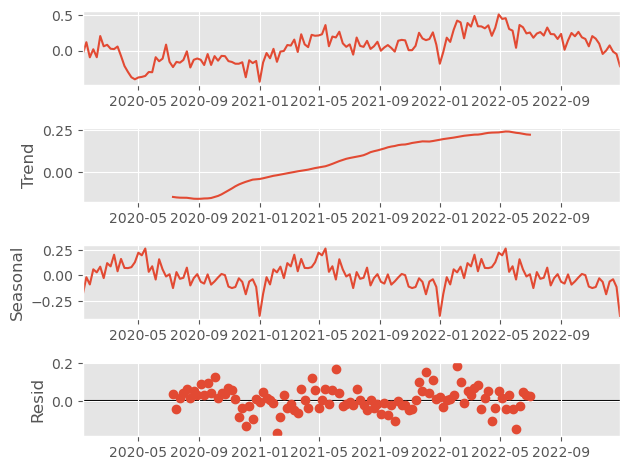

In [319]:
# upward trend even clearer with 52 week period
# 1y seasonality evident
# residuals look ok

sd = seasonal_decompose(df, period=52)
sd.plot()
plt.show()

<AxesSubplot: xlabel='date'>

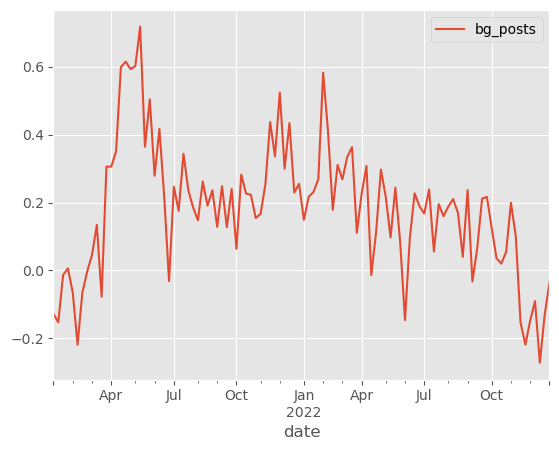

In [320]:
# visualizing 52 week shift / differencing

diff = df.dropna()
df_s_adj = diff - diff.shift(52)
df_s_adj = df_s_adj.dropna()
df_s_adj.plot()

In [322]:
# briefly looking at monthly data
df_monthly = df['bg_posts'].resample('MS').mean() # monthly frequency

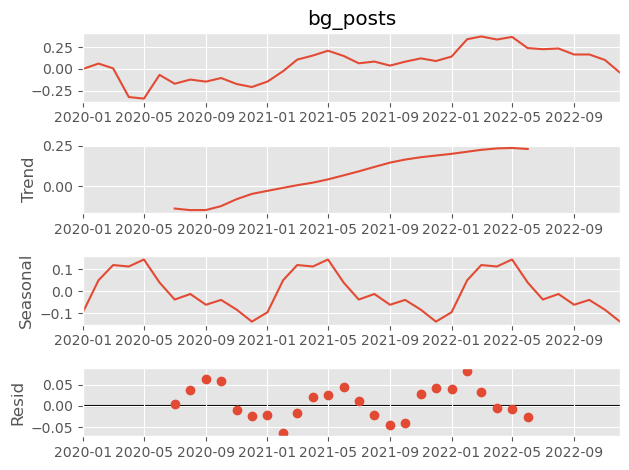

In [323]:
# smoother, but obvious seasonality and trend
# residuals not evenly spread out
# will stick with weekly data

sd = seasonal_decompose(df_monthly, period=12)
sd.plot()
plt.show()

#### Train Test Split

In [324]:
# weekly frequency
df = df['bg_posts'].resample('W-FRI').mean()
df = df.fillna(df.bfill())
df.head()

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

In [325]:
df.head()

date
2020-01-10   -0.0407
2020-01-17    0.1180
2020-01-24   -0.0954
2020-01-31    0.0183
2020-02-07   -0.0943
Freq: W-FRI, Name: bg_posts, dtype: float64

In [326]:
# data needs to stay in chronological order so we cut off last 80% and set aside for test
cutoff = round(df.shape[0]*0.8) 
cutoff

125

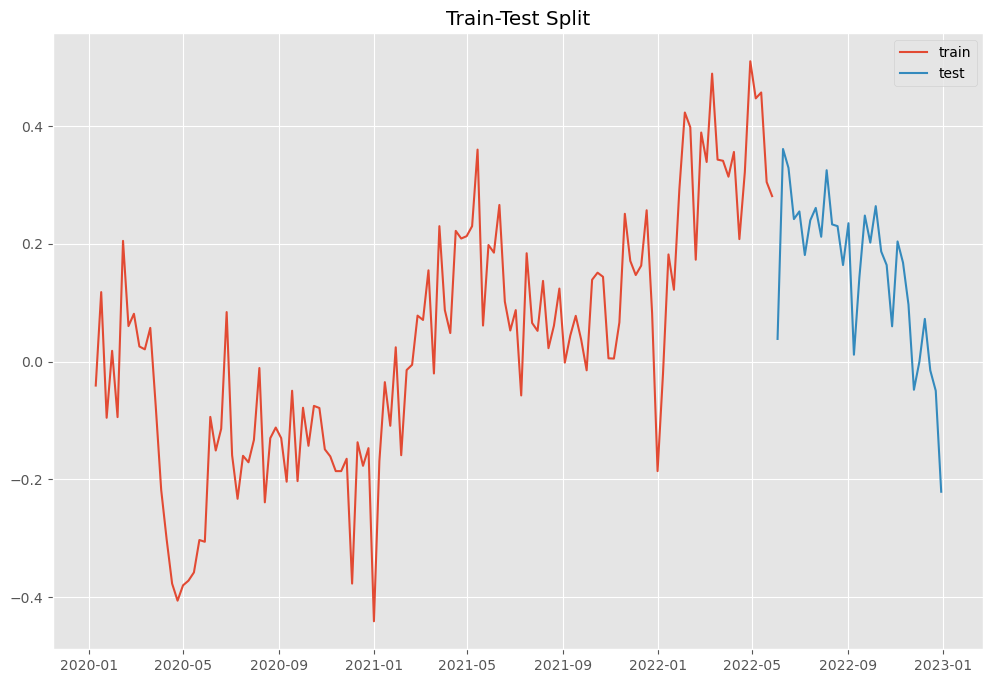

In [327]:
# train test split
train = df[:cutoff]
test = df[cutoff:]

# visualizing split
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [328]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 52 for frequency - yearly)
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [329]:
results = []

for comb in pdq:
    
    for combs in pdqs:
        
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=train,
                                            order=comb,
                                            seasonal_order=combs)
                                            #enforce_invertibility=False, 
                                            #enforce_stationarity=False)

            output = mod.fit()
            results.append([comb, combs, output.aic])
            
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        
        except: 
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30336D-01    |proj g|=  2.21640D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     14      1     0     0   2.216D-04  -1.303D-01
  F = -0.13033558207419485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 0, 0, 52): AIC Calculated=-30.583895518548715
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0      

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.33015D-01    |proj g|=  3.12541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     11      1     0     0   8.927D-07  -1.330D-01
  F = -0.13301524780163512     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 0, 1, 52): AIC Calculated=-29.25381195040878


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74406D-01    |proj g|=  1.82074D+00

At iterate    5    f=  1.23460D-01    |proj g|=  1.42469D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      5      8      1     0     0   1.425D-06   1.235D-01
  F =  0.12345977122922509     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 0, 52): AIC Calculated=32.86494280730628
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2

 This problem is unconstrained.



At iterate    5    f=  1.16355D-01    |proj g|=  2.48079D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     14      1     0     0   8.355D-08   1.163D-01
  F =  0.11626760266719087     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 1, 52): AIC Calculated=33.06690066679772
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30228D-01    |proj g|=  2.92109D-01

At iterate    5    f= -1.31298D-01    |proj g|=  6.19560D-03


 This problem is unconstrained.



At iterate   10    f= -1.31303D-01    |proj g|=  2.25052D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   2.251D-06  -1.313D-01
  F = -0.13130324053554118     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 0, 0, 52): AIC Calculated=-28.825810133885298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30141D-01    |proj g|=  1.34109D-01


 This problem is unconstrained.



At iterate    5    f= -1.44815D-01    |proj g|=  3.40531D-01

At iterate   10    f= -1.47219D-01    |proj g|=  2.25087D-02

At iterate   15    f= -1.47880D-01    |proj g|=  5.18566D-02

At iterate   20    f= -1.47972D-01    |proj g|=  2.71440D-03

At iterate   25    f= -1.47984D-01    |proj g|=  4.89722D-04

At iterate   30    f= -1.47986D-01    |proj g|=  8.33466D-04

At iterate   35    f= -1.47986D-01    |proj g|=  1.57639D-05

At iterate   40    f= -1.47986D-01    |proj g|=  7.93839D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     41     54      1     0     0   3.117D-04  -1.480D-01
  F = -0.147986012417

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25321D-01    |proj g|=  6.06805D-01

At iterate    5    f=  1.16346D-01    |proj g|=  1.87020D-02

At iterate   10    f=  1.16268D-01    |proj g|=  7.19295D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   7.193D-06   1.163D-01
  F =  0.11626760288683366     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 1, 0, 52): AIC Calculated=33.066900721708414
RUN

 This problem is unconstrained.



At iterate    5    f=  1.16291D-01    |proj g|=  2.29147D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   3.596D-06   1.163D-01
  F =  0.11626760266454622     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 1, 1, 52): AIC Calculated=35.066900666136554
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.40015D-01    |proj g|=  1.79239D+00

At iterate    5    f= -3.88258D-01    |proj g|=  1.11345D-02

  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -3.89186D-01    |proj g|=  2.17496D-01

At iterate   10    f= -3.90311D-01    |proj g|=  1.30881D-01

At iterate   15    f= -3.90847D-01    |proj g|=  1.56341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   9.576D-06  -3.908D-01
  F = -0.39084680253926263     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 0, 1, 52): AIC Calculated=-91.71170063481566


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.28657D-03    |proj g|=  8.56125D-01

At iterate    5    f= -5.35136D-02    |proj g|=  2.05495D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   2.758D-06  -5.351D-02
  F =  -5.3513713172915409E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 1, 0, 52): AIC Calculated=-9.378428293228852
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 

 This problem is unconstrained.



At iterate    5    f= -5.44329D-02    |proj g|=  9.54541D-03

At iterate   10    f= -5.46754D-02    |proj g|=  3.43573D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   9.431D-05  -5.471D-02
  F =  -5.4705797098029953E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 1, 1, 52): AIC Calculated=-7.676449274507489
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.37491D-01    |proj g|=  1.77698D+00

At

 This problem is unconstrained.



At iterate   10    f= -3.89754D-01    |proj g|=  1.20308D-02

At iterate   15    f= -3.89854D-01    |proj g|=  4.20405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     23      1     0     0   1.453D-04  -3.899D-01
  F = -0.38985395692083435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 0, 0, 52): AIC Calculated=-91.4634892302086
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.40015D-01    |proj g|=  1.79239D+00


 This problem is unconstrained.



At iterate    5    f= -3.88789D-01    |proj g|=  2.65533D-01

At iterate   10    f= -3.90247D-01    |proj g|=  1.32019D-02

At iterate   15    f= -3.90586D-01    |proj g|=  1.18349D-01

At iterate   20    f= -3.98868D-01    |proj g|=  1.20439D-01

At iterate   25    f= -3.99340D-01    |proj g|=  7.95755D-03

At iterate   30    f= -3.99743D-01    |proj g|=  8.17264D-03

At iterate   35    f= -3.99800D-01    |proj g|=  2.64465D-03

At iterate   40    f= -3.99809D-01    |proj g|=  2.52549D-03

At iterate   45    f= -3.99811D-01    |proj g|=  5.34605D-04

At iterate   50    f= -3.99811D-01    |proj g|=  8.56163D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26003D-04    |proj g|=  8.99092D-01

At iterate    5    f= -5.44938D-02    |proj g|=  8.56146D-03

At iterate   10    f= -5.47058D-02    |proj g|=  9.11228D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     27      1     0     0   2.532D-05  -5.471D-02
  F =  -5.4705797993758895E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (0, 0, 1) x (1, 1, 0, 52): AIC Calculated=-7.676449498439723
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.28657D-03    |proj g|=  8.56125D-01


 This problem is unconstrained.



At iterate    5    f= -5.47038D-02    |proj g|=  4.97766D-03

At iterate   10    f= -5.47058D-02    |proj g|=  1.26920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   1.362D-04  -5.471D-02
  F =  -5.4705798154296874E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 1, 1, 52): AIC Calculated=-5.676449538574218
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.44859D-01    |proj g|=  6.29484D-02

  

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -6.66560D-01    |proj g|=  1.52468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   1.057D-05  -6.666D-01
  F = -0.66656043251987940     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 0, 1, 52): AIC Calculated=-162.64010812996986


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.10857D-01    |proj g|=  3.65066D+00

At iterate    5    f= -2.63981D-01    |proj g|=  1.31050D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      8     50      2     0     0   1.439D-04  -2.640D-01
  F = -0.26398286122472014     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA (0, 1, 0) x (0, 1, 0, 52): AIC Calculated=-63.99571530618003



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.63954D-01    |proj g|=  1.00139D-01

At iterate    5    f= -2.93747D-01    |proj g|=  6.75805D-03

At iterate   10    f= -2.94773D-01    |proj g|=  4.37848D-02

At iterate   15    f= -2.94855D-01    |proj g|=  8.00789D-03

At iterate   20    f= -2.94856D-01    |proj g|=  3.13552D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     35      1     0     0   5.133D-04  -2.949D-01
  F = -0.29485556922554235     

CONVERG

 This problem is unconstrained.



At iterate   10    f= -6.69359D-01    |proj g|=  1.36165D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   8.382D-06  -6.694D-01
  F = -0.66935936534081886     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (1, 0, 0, 52): AIC Calculated=-163.3398413352047
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.44857D-01    |proj g|=  1.70224D-01


 This problem is unconstrained.



At iterate    5    f= -6.67993D-01    |proj g|=  5.12058D-03

At iterate   10    f= -6.68072D-01    |proj g|=  1.29536D-01

At iterate   15    f= -6.71148D-01    |proj g|=  7.15503D-01

At iterate   20    f= -6.73081D-01    |proj g|=  3.96212D-02

At iterate   25    f= -6.73254D-01    |proj g|=  2.18503D-02

At iterate   30    f= -6.73310D-01    |proj g|=  3.48347D-03

At iterate   35    f= -6.73324D-01    |proj g|=  6.74429D-03

At iterate   40    f= -6.73328D-01    |proj g|=  7.65069D-03

At iterate   45    f= -6.73329D-01    |proj g|=  2.42255D-03

At iterate   50    f= -6.73331D-01    |proj g|=  8.01683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -2.94923D-01    |proj g|=  3.66430D-02

At iterate   10    f= -2.95175D-01    |proj g|=  1.61518D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     54      2     0     0   9.206D-05  -2.952D-01
  F = -0.29517554349103592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 0, 52): AIC Calculated=-69.79388587275898
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.63954D-01    |proj g|=  1.00139D-01


 This problem is unconstrained.



At iterate    5    f= -2.95171D-01    |proj g|=  2.40657D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     25      1     0     0   1.524D-04  -2.952D-01
  F = -0.29517554248406680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (0, 1, 0) x (1, 1, 1, 52): AIC Calculated=-67.7938856210167
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57717D-01    |proj g|=  1.42385D-02

At iterate    5    f= -7.57904D-01    |proj g|=  8.10862D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     10      1     0     0   8.109D-07  -7.579D-01
  F = -0.75790448283580591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 0, 52): AIC Calculated=-185.4761207089514

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.74405D-01    |proj g|=  1.50816D-02

At iterate   10    f= -7.74587D-01    |proj g|=  7.35226D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   6.206D-06  -7.746D-01
  F = -0.77461886036265948     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 1, 52): AIC Calculated=-187.65471509066487
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24111D-01    |proj g|=  1.30248D-01


 This problem is unconstrained.



At iterate    5    f= -3.26449D-01    |proj g|=  1.32073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     16      1     0     0   4.735D-05  -3.265D-01
  F = -0.32645041403857072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 0, 52): AIC Calculated=-77.61260350964268
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24111D-01    |proj g|=  1.30248D-01


 This problem is unconstrained.



At iterate    5    f= -3.46657D-01    |proj g|=  2.66647D-02

At iterate   10    f= -3.46994D-01    |proj g|=  2.55389D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     20      1     0     0   2.500D-04  -3.470D-01
  F = -0.34699354507021429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 1, 52): AIC Calculated=-80.74838626755357
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.75079D-01    |proj g|=  6.00169D-01


 This problem is unconstrained.



At iterate    5    f= -7.76417D-01    |proj g|=  4.26681D-02

At iterate   10    f= -7.76424D-01    |proj g|=  3.34241D-03

At iterate   15    f= -7.76425D-01    |proj g|=  8.39108D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     39      1     0     0   8.391D-05  -7.764D-01
  F = -0.77642512665370422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 0, 52): AIC Calculated=-188.10628166342605
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -7.75471D-01    |proj g|=  1.82058D-02

At iterate   10    f= -7.75623D-01    |proj g|=  4.22252D-02

At iterate   15    f= -7.75769D-01    |proj g|=  1.74822D-01

At iterate   20    f= -7.77058D-01    |proj g|=  2.23173D-02

At iterate   25    f= -7.77922D-01    |proj g|=  1.98930D-03

At iterate   30    f= -7.77924D-01    |proj g|=  1.17582D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     39      1     0     0   1.176D-03  -7.779D-01
  F = -0.77792374707797951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 1, 52): AIC Calculated=-18

 This problem is unconstrained.



At iterate    5    f= -3.38379D-01    |proj g|=  9.70643D-02

At iterate   10    f= -3.45768D-01    |proj g|=  1.90508D-01

At iterate   15    f= -3.46179D-01    |proj g|=  1.22109D-01

At iterate   20    f= -3.46993D-01    |proj g|=  2.25802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     30      1     0     0   3.726D-05  -3.470D-01
  F = -0.34699354430537643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 0, 52): AIC Calculated=-80.7483860763441
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -3.46987D-01    |proj g|=  4.56359D-03

At iterate   10    f= -3.46994D-01    |proj g|=  7.82823D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   7.828D-05  -3.470D-01
  F = -0.34699354396048920     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 52): AIC Calculated=-78.7483859901223
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.92135D-01    |proj g|=  6.44458D-02

At 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.12136D-01    |proj g|=  1.53269D-03

At iterate   10    f= -7.12148D-01    |proj g|=  2.21156D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.106D-07  -7.121D-01
  F = -0.71214777834557186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 0, 1, 52): AIC Calculated=-172.03694458639296
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85015D-01    |proj g|=  4.45639D-02

A

 This problem is unconstrained.



At iterate   10    f= -2.85136D-01    |proj g|=  1.35182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     18      1     0     0   2.253D-04  -2.851D-01
  F = -0.28513637137917158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 0, 52): AIC Calculated=-67.2840928447929


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85015D-01    |proj g|=  8.72599D-02

At iterate    5    f= -3.06894D-01    |proj g|=  3.79687D-02

At iterate   10    f= -3.08569D-01    |proj g|=  1.93933D-02

At iterate   15    f= -3.08607D-01    |proj g|=  5.13028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     27      1     0     0   2.419D-03  -3.086D-01
  F = -0.30860802891999867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1

 This problem is unconstrained.



At iterate    5    f= -7.12912D-01    |proj g|=  9.80032D-03

At iterate   10    f= -7.13023D-01    |proj g|=  9.60482D-02

At iterate   15    f= -7.13087D-01    |proj g|=  4.30677D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     20      1     0     0   4.307D-05  -7.131D-01
  F = -0.71308666274848842     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 0, 0, 52): AIC Calculated=-172.2716656871221
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -7.12642D-01    |proj g|=  3.64987D-03

At iterate   10    f= -7.12726D-01    |proj g|=  3.44037D-02

At iterate   15    f= -7.12797D-01    |proj g|=  1.62683D-02

At iterate   20    f= -7.13263D-01    |proj g|=  2.70686D-02

At iterate   25    f= -7.13321D-01    |proj g|=  3.55795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   3.752D-06  -7.133D-01
  F = -0.71332120758426210     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (1, 0, 1, 52): AIC Calculated=-170.33030189606552
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -3.07454D-01    |proj g|=  6.33759D-02

At iterate   10    f= -3.08586D-01    |proj g|=  6.76008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     22      1     0     0   1.502D-05  -3.086D-01
  F = -0.30858614485992597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 0, 52): AIC Calculated=-71.1465362149815
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85015D-01    |proj g|=  8.72599D-02


 This problem is unconstrained.



At iterate    5    f= -3.07188D-01    |proj g|=  1.05573D-02

At iterate   10    f= -3.08595D-01    |proj g|=  6.86444D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     24      1     0     0   7.020D-04  -3.086D-01
  F = -0.30859545362504714     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 1, 52): AIC Calculated=-69.14886340626178
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.68321D-01    |proj g|=  1.17133D-01

At

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.86418D-01    |proj g|=  1.86704D-02

At iterate   10    f= -7.86515D-01    |proj g|=  9.93742D-02

At iterate   15    f= -7.86606D-01    |proj g|=  2.87944D-03

At iterate   20    f= -7.86680D-01    |proj g|=  6.71129D-02

At iterate   25    f= -7.87295D-01    |proj g|=  8.42771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   1.242D-06  -7.873D-01
  F = -0.78729529386661234     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (0, 0, 1, 52): AIC Calculated=-188.8238234666531
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate   10    f= -3.32237D-01    |proj g|=  8.32623D-03

At iterate   15    f= -3.33008D-01    |proj g|=  1.20862D-01

At iterate   20    f= -3.33850D-01    |proj g|=  5.97677D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     33      1     0     0   9.107D-05  -3.338D-01
  F = -0.33384964761890118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 0, 52): AIC Calculated=-77.4624119047253
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -3.51675D-01    |proj g|=  5.43403D-02

At iterate   10    f= -3.52001D-01    |proj g|=  5.81851D-03

At iterate   15    f= -3.52036D-01    |proj g|=  3.94023D-02

At iterate   20    f= -3.52058D-01    |proj g|=  1.84930D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   4.605D-04  -3.521D-01
  F = -0.35205827234733517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 1, 52): AIC Calculated=-80.01456808683379
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -7.87491D-01    |proj g|=  2.13594D-02

At iterate   10    f= -7.87852D-01    |proj g|=  6.87789D-02

At iterate   15    f= -7.87870D-01    |proj g|=  6.99364D-03

At iterate   20    f= -7.88014D-01    |proj g|=  3.48942D-02

At iterate   25    f= -7.88384D-01    |proj g|=  8.53734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   8.556D-06  -7.884D-01
  F = -0.78838561286477582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (1, 0, 0, 52): AIC Calculated=-189.09640321619395
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -7.87294D-01    |proj g|=  1.37385D-02

At iterate   10    f= -7.87366D-01    |proj g|=  1.48198D-02

At iterate   15    f= -7.87830D-01    |proj g|=  3.48667D-01

At iterate   20    f= -7.88668D-01    |proj g|=  3.01477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   8.286D-05  -7.887D-01
  F = -0.78866847498427972     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 0, 1, 52): AIC Calculated=-187.16711874606992
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -3.51476D-01    |proj g|=  1.23941D-02

At iterate   10    f= -3.51636D-01    |proj g|=  6.81819D-04

At iterate   15    f= -3.51690D-01    |proj g|=  3.81245D-02

At iterate   20    f= -3.51791D-01    |proj g|=  1.32283D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   5.022D-05  -3.518D-01
  F = -0.35179153762873683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 0, 52): AIC Calculated=-79.9478844071842
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =         

 This problem is unconstrained.



At iterate    5    f= -3.51676D-01    |proj g|=  1.00503D-02

At iterate   10    f= -3.51785D-01    |proj g|=  7.33189D-04

At iterate   15    f= -3.51869D-01    |proj g|=  8.11275D-03

At iterate   20    f= -3.52019D-01    |proj g|=  2.67442D-03

At iterate   25    f= -3.52028D-01    |proj g|=  1.76231D-02

At iterate   30    f= -3.52103D-01    |proj g|=  8.51360D-03

At iterate   35    f= -3.52141D-01    |proj g|=  3.50160D-03

At iterate   40    f= -3.52166D-01    |proj g|=  3.02022D-03

At iterate   45    f= -3.52169D-01    |proj g|=  2.34455D-03
  ys=-2.392E-06  -gs= 2.367E-06 BFGS update SKIPPED

At iterate   50    f= -3.52174D-01    |proj g|=  4.61304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.60515D-01    |proj g|=  1.39549D-03

At iterate   10    f= -7.60517D-01    |proj g|=  1.53331D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   3.592D-06  -7.605D-01
  F = -0.76051674830497951     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 0, 1, 52): AIC Calculated=-184.12918707624488
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27189D-01    |proj g|=  5.68706D-02


 This problem is unconstrained.



At iterate    5    f= -3.27219D-01    |proj g|=  1.53277D-02

At iterate   10    f= -3.27229D-01    |proj g|=  1.76129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     18      1     0     0   1.519D-04  -3.272D-01
  F = -0.32722856608956791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 0, 52): AIC Calculated=-77.80714152239197
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27189D-01    |proj g|=  9.39367D-02


 This problem is unconstrained.



At iterate    5    f= -3.49208D-01    |proj g|=  8.78380D-02

At iterate   10    f= -3.49620D-01    |proj g|=  5.76936D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     23      1     0     0   5.914D-04  -3.496D-01
  F = -0.34962031977081359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 1, 52): AIC Calculated=-81.4050799427034
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.61204D-01    |proj g|=  6.17062D-01


 This problem is unconstrained.



At iterate    5    f= -7.62524D-01    |proj g|=  1.79418D-02

At iterate   10    f= -7.62545D-01    |proj g|=  1.27466D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f= -7.62545D-01    |proj g|=  5.67357D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     36      1     0     0   5.674D-05  -7.625D-01
  F = -0.76254473947490764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 0, 0, 52): AIC Calculated=-184.6361848687269
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.39592D-01    |proj g|=  1.57855D-01


 This problem is unconstrained.



At iterate    5    f= -7.61586D-01    |proj g|=  2.01495D-02

At iterate   10    f= -7.61620D-01    |proj g|=  8.33552D-02

At iterate   15    f= -7.61920D-01    |proj g|=  4.08271D-02

At iterate   20    f= -7.62688D-01    |proj g|=  3.49247D-01

At iterate   25    f= -7.63426D-01    |proj g|=  5.50395D-02

At iterate   30    f= -7.63849D-01    |proj g|=  9.11927D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     76      2     0     0   4.872D-04  -7.639D-01
  F = -0.76385138681684017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (1, 1, 0) x (1, 0, 1, 52): AIC Calculated=-182.96284670421005
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27404D-01    |proj g|=  1.27671D+00


 This problem is unconstrained.



At iterate    5    f= -3.44603D-01    |proj g|=  3.83802D-02

At iterate   10    f= -3.48295D-01    |proj g|=  2.88582D-01

At iterate   15    f= -3.48984D-01    |proj g|=  9.13263D-02

At iterate   20    f= -3.49616D-01    |proj g|=  1.85618D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     29      1     0     0   2.591D-04  -3.496D-01
  F = -0.34962031729657267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 0, 52): AIC Calculated=-81.40507932414317
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -3.49505D-01    |proj g|=  9.18266D-03

At iterate   10    f= -3.49620D-01    |proj g|=  5.66780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   2.542D-05  -3.496D-01
  F = -0.34962032006439425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 1, 52): AIC Calculated=-79.40508001609857
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57617D-01    |proj g|=  2.14193D-02

At

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57617D-01    |proj g|=  1.44594D-01

At iterate    5    f= -7.74996D-01    |proj g|=  3.57280D-03

At iterate   10    f= -7.75084D-01    |proj g|=  1.33559D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     20      1     0     0   1.361D-04  -7.751D-01
  F = -0.77508357708045983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 0, 1, 52): AIC Calculated=-185.77089427011495
RU

 This problem is unconstrained.



At iterate    5    f= -3.30932D-01    |proj g|=  1.63576D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   1.764D-04  -3.309D-01
  F = -0.33094223167091363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 0, 52): AIC Calculated=-76.73555791772841
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30651D-01    |proj g|=  1.50907D-01


 This problem is unconstrained.



At iterate    5    f= -3.49924D-01    |proj g|=  3.44181D-02

At iterate   10    f= -3.50641D-01    |proj g|=  2.31730D-03

At iterate   15    f= -3.50754D-01    |proj g|=  5.36154D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   6.709D-04  -3.508D-01
  F = -0.35075385446411550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 1, 52): AIC Calculated=-79.68846361602887
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -7.76833D-01    |proj g|=  1.98415D-02

At iterate   10    f= -7.76892D-01    |proj g|=  2.54976D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     20      1     0     0   1.493D-04  -7.769D-01
  F = -0.77689402531544982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 0, 52): AIC Calculated=-186.22350632886244
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57617D-01    |proj g|=  1.44600D-01


 This problem is unconstrained.



At iterate    5    f= -7.75744D-01    |proj g|=  7.51056D-02

At iterate   10    f= -7.75969D-01    |proj g|=  1.47421D-02

At iterate   15    f= -7.76193D-01    |proj g|=  1.68388D-01

At iterate   20    f= -7.76670D-01    |proj g|=  1.66596D-02

At iterate   25    f= -7.77985D-01    |proj g|=  8.56664D-02

At iterate   30    f= -7.78257D-01    |proj g|=  1.13165D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     53      1     0     0   4.388D-04  -7.783D-01
  F = -0.77825761844443275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 1, 52): AIC Calculated=-184.5644046111082
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.25949D-01    |proj g|=  1.29360D+00


 This problem is unconstrained.



At iterate    5    f= -3.44157D-01    |proj g|=  8.01833D-02

At iterate   10    f= -3.48222D-01    |proj g|=  2.38777D-02

At iterate   15    f= -3.50235D-01    |proj g|=  2.33432D-01

At iterate   20    f= -3.50654D-01    |proj g|=  5.34981D-03

At iterate   25    f= -3.50754D-01    |proj g|=  7.82013D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   1.814D-04  -3.508D-01
  F = -0.35075385714502216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 0, 52): AIC Calculated=-79.68846428625554
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -3.50502D-01    |proj g|=  6.46962D-02

At iterate   10    f= -3.50586D-01    |proj g|=  1.79659D-02

At iterate   15    f= -3.50734D-01    |proj g|=  2.75049D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   7.048D-05  -3.508D-01
  F = -0.35075385363412520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 1, 52): AIC Calculated=-77.6884634085313


In [330]:
results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
results_df.loc[results_df['aic'].idxmin()]

order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
seasonal_order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

In [331]:
sari_mod = sm.tsa.statespace.SARIMAX(train,
                                     order=order,
                                     seasonal_order=seasonal_order).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.57395D-01    |proj g|=  1.81562D-01


 This problem is unconstrained.



At iterate    5    f= -7.87491D-01    |proj g|=  2.13594D-02

At iterate   10    f= -7.87852D-01    |proj g|=  6.87789D-02

At iterate   15    f= -7.87870D-01    |proj g|=  6.99364D-03

At iterate   20    f= -7.88014D-01    |proj g|=  3.48942D-02

At iterate   25    f= -7.88384D-01    |proj g|=  8.53734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   8.556D-06  -7.884D-01
  F = -0.78838561286477582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [332]:
# Fit the model and print results
print(sari_mod.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            bg_posts   No. Observations:                  125
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                  98.548
Date:                             Thu, 02 Feb 2023   AIC                           -189.096
Time:                                     12:21:03   BIC                           -177.783
Sample:                                 01-10-2020   HQIC                          -184.500
                                      - 05-27-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9536      0.031     30.506      0.000       0.892       1.015
ma.L1         -0.4428      

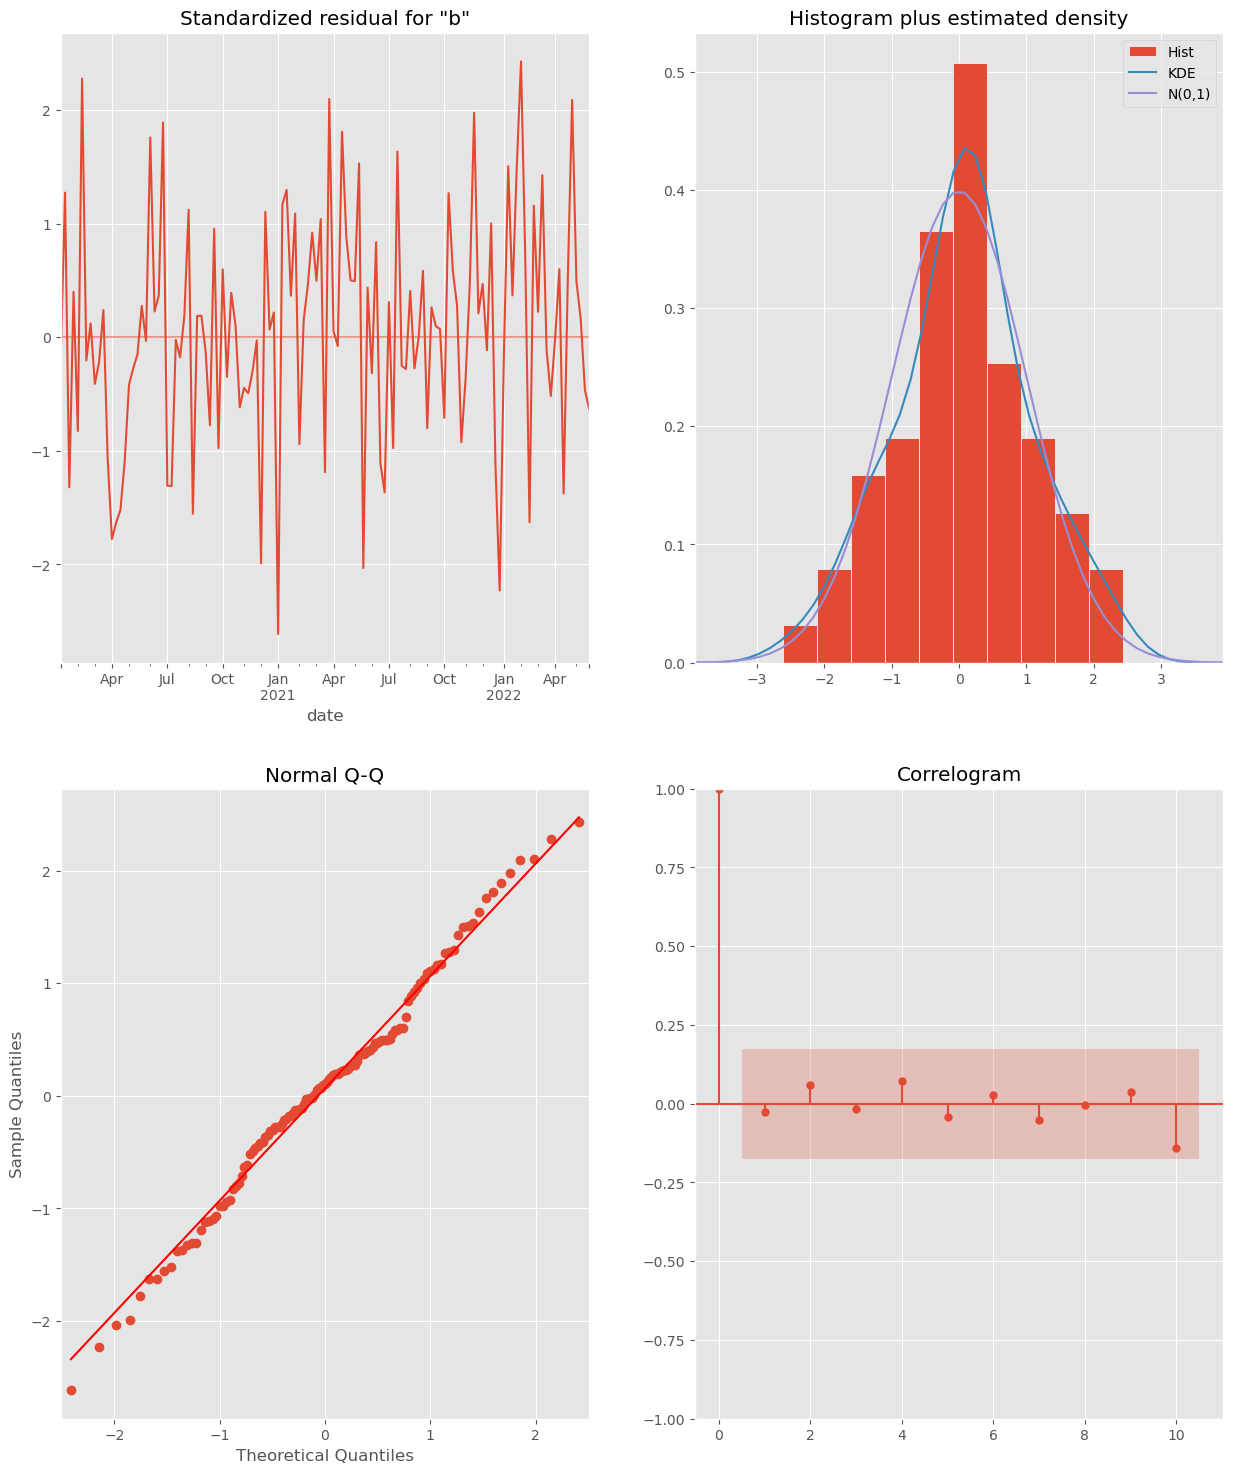

<Figure size 640x480 with 0 Axes>

In [333]:
sari_mod.plot_diagnostics(figsize=(15, 18))
plt.show()
plt.savefig('assets/timeseries_diagnostics.png')

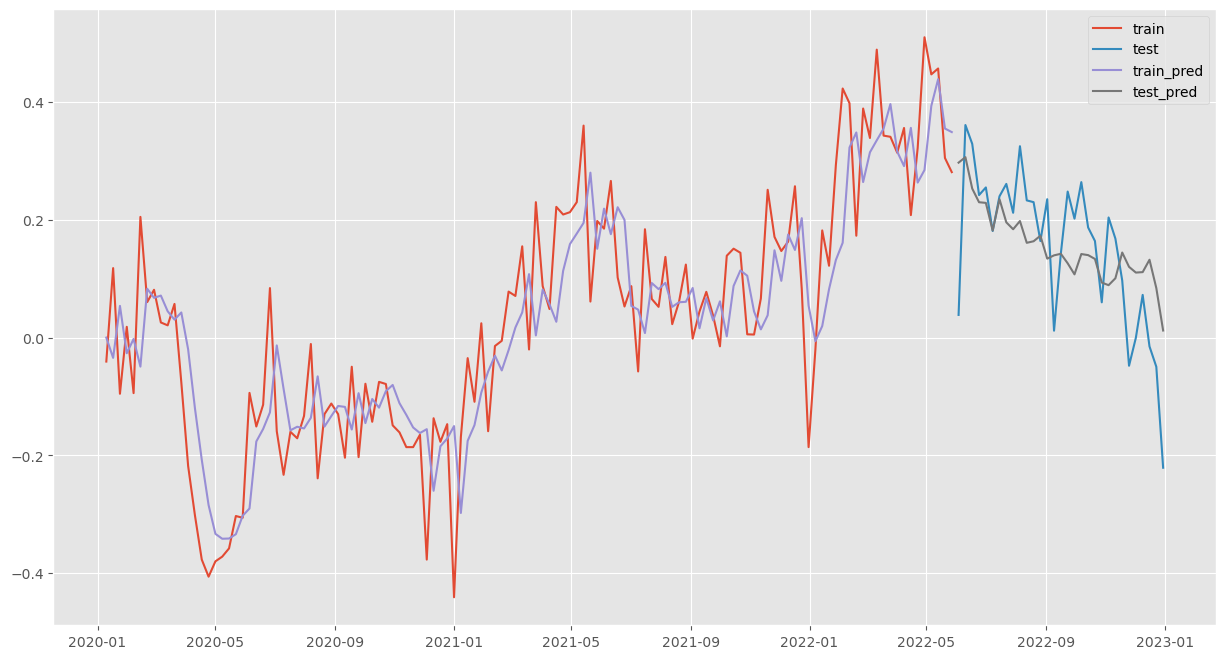

In [334]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1], 
                              typ='levels', dynamic=True)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train, label='train')
ax.plot(test, label='test') # valid
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend()

plt.savefig('assets/timeseries_validation.png');

In [335]:
print("MSE, train: ", str(np.sqrt(mean_squared_error(train, y_hat_train))))

error = np.sqrt(mean_squared_error(test, y_hat_test))
print("MSE, test: ", str(error))

MSE, train:  0.10948173385866404
MSE, test:  0.10358723013923056


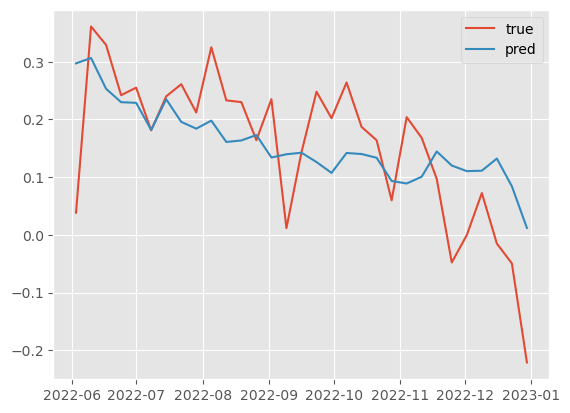

In [336]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

#### Forecast

In [337]:
# running model on full series
sari_mod_final = sm.tsa.statespace.SARIMAX(df,
                                           order=order,
                                           seasonal_order=seasonal_order).fit()

forecast = sari_mod_final.forecast(steps=52, dynamic=True)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02648D-01    |proj g|=  4.23456D-01


 This problem is unconstrained.



At iterate    5    f= -8.12667D-01    |proj g|=  2.18992D-02

At iterate   10    f= -8.12701D-01    |proj g|=  7.55498D-02

At iterate   15    f= -8.12755D-01    |proj g|=  1.08171D-03

At iterate   20    f= -8.12767D-01    |proj g|=  1.90905D-02

At iterate   25    f= -8.12834D-01    |proj g|=  1.09846D-02

At iterate   30    f= -8.12835D-01    |proj g|=  1.40499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   8.133D-06  -8.128D-01
  F = -0.81283538551282652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


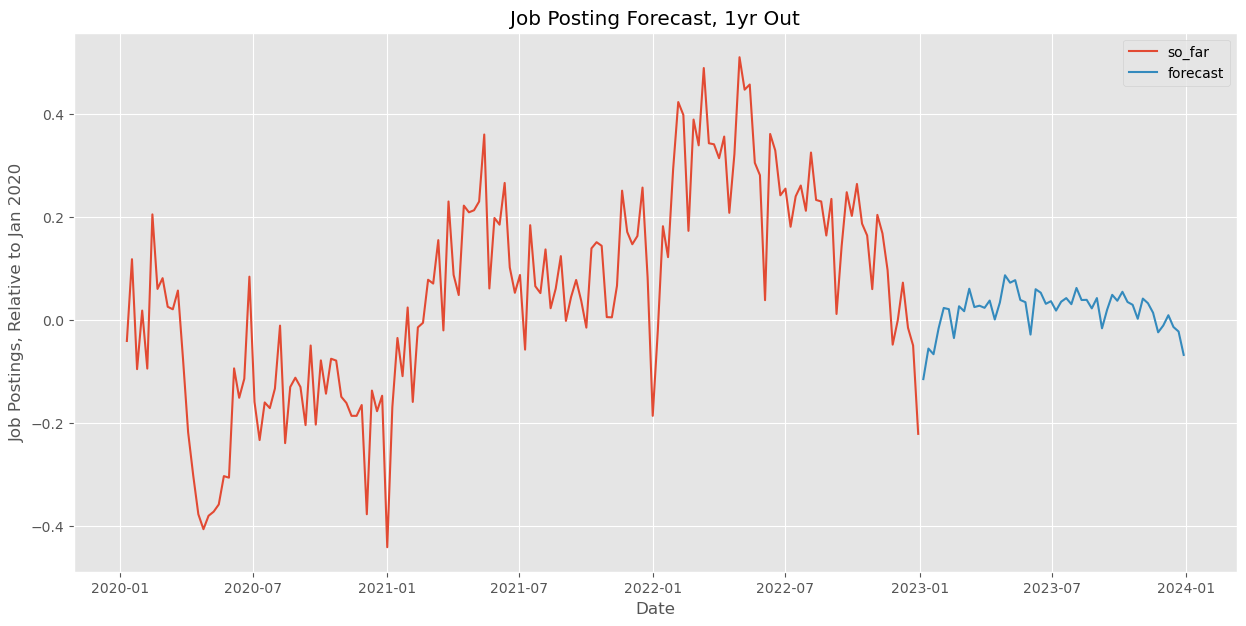

In [338]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Job Posting Forecast, 1yr Out')
ax.set_xlabel('Date')
ax.set_ylabel('Job Postings, Relative to Jan 2020')

plt.legend()

plt.savefig('assets/job_forecast.png');

In [339]:
# storing preds in dataframe
forecast_df = pd.DataFrame(forecast).reset_index()
forecast_df.columns = ['date', 'prediction']
forecast_df.to_csv('data/jobs_forecast.csv')

In [340]:
forecast_df.head()

,date,prediction
0,2023-01-06,-0.114719
1,2023-01-13,-0.055429
2,2023-01-20,-0.066422
3,2023-01-27,-0.015941
4,2023-02-03,0.023354
5,2023-02-10,0.021015
6,2023-02-17,-0.034971
7,2023-02-24,0.026671
8,2023-03-03,0.017052
9,2023-03-10,0.060688


<AxesSubplot: >

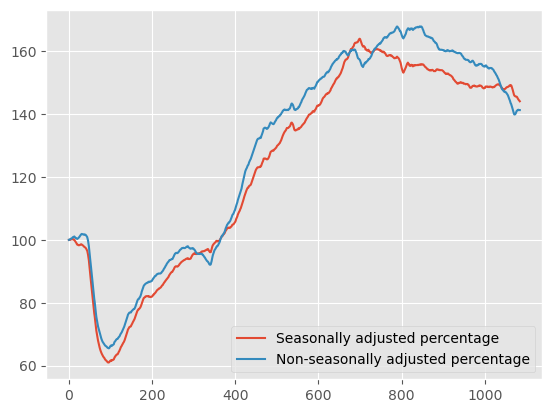

In [341]:
# indeed

indeed_jobs[['Date', 'Seasonally adjusted percentage', 'Non-seasonally adjusted percentage']].plot()

#### Facebook Prophet Model - To Be Continued

In [342]:
from prophet import Prophet

In [343]:
df_prophet = job_postings_national[['date', 'bg_posts']]
df_prophet = df_prophet.rename(columns={'date': 'ds', 'bg_posts': 'y'})

In [344]:
Model = Prophet(interval_width=0.95)
Model.fit(df_prophet)

12:21:07 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing


In [345]:
future_dates = Model.make_future_dataframe(periods=52, freq='W-SAT')
future_dates.tail()

,ds
203,2023-11-25
204,2023-12-02
205,2023-12-09
206,2023-12-16
207,2023-12-23


In [346]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-10,-0.208884,-0.554276,-0.077264,-0.208884,-0.208884,-0.097315,-0.097315,-0.097315,-0.097315,-0.097315,-0.097315,0.0,0.0,0.0,-0.306200
1,2020-01-17,-0.205506,-0.414179,0.069350,-0.205506,-0.205506,0.039271,0.039271,0.039271,0.039271,0.039271,0.039271,0.0,0.0,0.0,-0.166235
2,2020-01-24,-0.202128,-0.330219,0.157762,-0.202128,-0.202128,0.119544,0.119544,0.119544,0.119544,0.119544,0.119544,0.0,0.0,0.0,-0.082583
3,2020-01-31,-0.198749,-0.290584,0.164222,-0.198749,-0.198749,0.126872,0.126872,0.126872,0.126872,0.126872,0.126872,0.0,0.0,0.0,-0.071877
4,2020-02-07,-0.195371,-0.329047,0.183007,-0.195371,-0.195371,0.108079,0.108079,0.108079,0.108079,0.108079,0.108079,0.0,0.0,0.0,-0.087291


In [347]:
# Subset above mentioned columns and view the tail 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
203,2023-11-25,0.343216,0.101681,0.570949
204,2023-12-02,0.360484,0.123045,0.615892
205,2023-12-09,0.361987,0.123172,0.581019
206,2023-12-16,0.320453,0.079532,0.557753
207,2023-12-23,0.259500,0.005798,0.498798


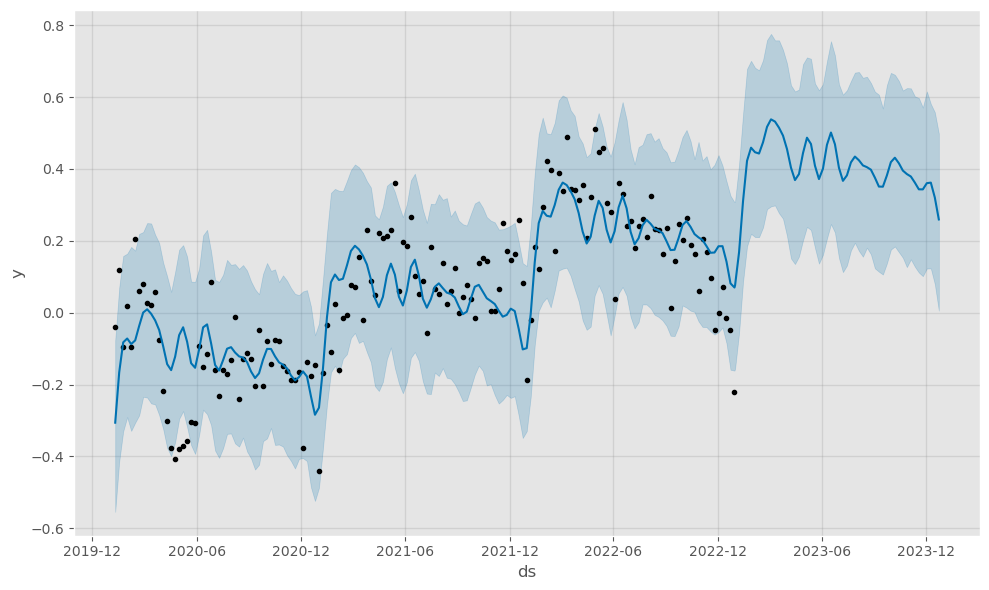

In [348]:
# Use Prophet's plot method to plot the predictions
Model.plot(forecast, uncertainty=True)
plt.show()

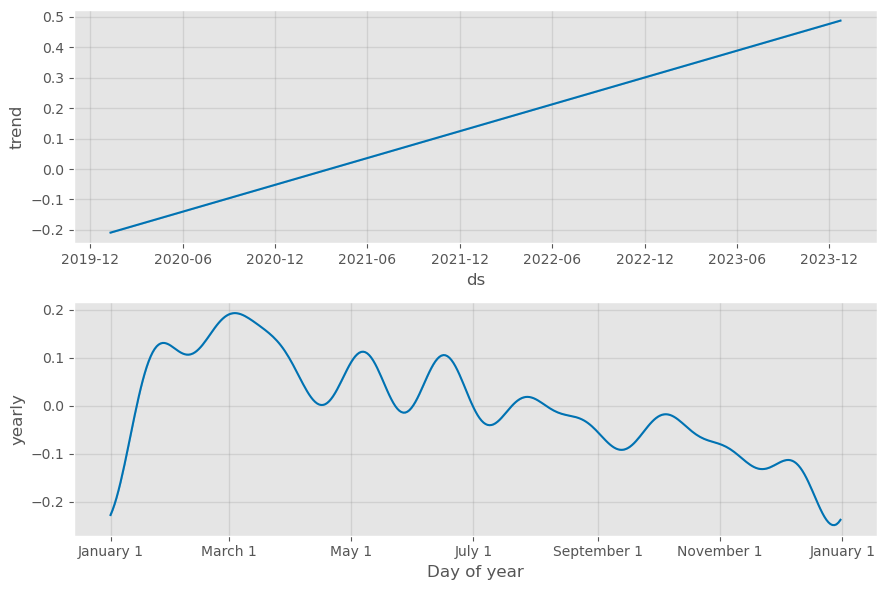

In [349]:
# Plot model components 
Model.plot_components(forecast)
plt.show()

# Supervised Models

### Data Prep

In [606]:
layoffs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2110 non-null   object 
 1   location             2110 non-null   object 
 2   industry             2109 non-null   object 
 3   total_laid_off       1453 non-null   float64
 4   percentage_laid_off  1420 non-null   float64
 5   date                 2110 non-null   object 
 6   stage                2104 non-null   object 
 7   country              2110 non-null   object 
 8   funds_raised         2110 non-null   float64
dtypes: float64(3), object(6)
memory usage: 148.5+ KB


In [607]:
layoffs_raw.isnull().sum()

company                  0
location                 0
industry                 1
total_laid_off         657
percentage_laid_off    690
date                     0
stage                    6
country                  0
funds_raised             0
dtype: int64

In [608]:
# converting to numeric type
layoffs_raw['funds_raised'] = pd.to_numeric(layoffs_raw['funds_raised'], 
                                            errors='coerce')

In [609]:
# replacing missing value of funds raised with median
layoffs_raw['funds_raised'].fillna(layoffs_raw['funds_raised'].median(), 
                                   inplace=True)

In [610]:
# converting to datetime, adding column for year
layoffs_raw['date'] = pd.to_datetime(layoffs_raw['date'])
layoffs_raw['year'] = [day.year for day in layoffs_raw['date']]

In [611]:
# getting rid of nans (very few for this subset)
layoffs_raw = layoffs_raw.dropna(subset=['industry', 'stage']).reset_index(drop=True)

In [612]:
# checking for duplicates
layoffs_raw[layoffs_raw.duplicated()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year
482,science 37,Los Angeles,Healthcare,90.0,NaN,2022-11-14,IPO,United States,347.0,2022
1245,cazoo,London,Transportation,750.0,0.15,2022-06-07,IPO,United Kingdom,2000.0,2022


In [613]:
# after some research, it appears there were indeed two rounds of layoffs
# for Cazoo
layoffs_raw[layoffs_raw.company=='cazoo']

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year
96,cazoo,London,Transportation,NaN,NaN,2023-01-18,IPO,United Kingdom,2000.0,2023
1244,cazoo,London,Transportation,750.0,0.15,2022-06-07,IPO,United Kingdom,2000.0,2022
1245,cazoo,London,Transportation,750.0,0.15,2022-06-07,IPO,United Kingdom,2000.0,2022


In [614]:
# second round of layoffs were on 9/8/2022
# source: https://sifted.eu/articles/cazoo-layoffs-european-union/ 

layoffs_raw.iloc[1245]['date'] = '2022-09-08' # adding correct value

In [615]:
# layoffs_sorted = layoffs_raw[['company', 'funds_raised', 'date']].sort_values(by='date')
# # funds raised in first round of layoffs and
# #year of first layoffs

# ff = layoffs_sorted.drop_duplicates(subset=['company'], keep='first')
# ff['year_fr'] = [day.year for day in ff.date]
# ff.columns=['company', 'funds_raised_fr', 'date_fr', 'year_fr']

# ff[ff.company=='uber']

In [616]:
# list of companies that had more than one round of layoffs
mult_layoffs = list(layoffs_raw.company.value_counts()[layoffs_raw.company.value_counts() > 1].index)

In [617]:
len(mult_layoffs)

292

In [618]:
data_classification = layoffs_raw.drop(['total_laid_off', 'percentage_laid_off', 
                                        'date', 'year'], axis=1)

grouped = data_classification.groupby(by=['company', 'location', 'industry', 
                                          'stage', 'country']).sum().reset_index()

In [619]:
data_classification['multiple'] = [True if co in mult_layoffs else False 
                                   for co in data_classification.company]
data_classification.tail()

,company,location,industry,stage,country,funds_raised,multiple
2098,service,Los Angeles,Travel,Seed,United States,5.1,True
2099,hopskipdrive,Los Angeles,Transportation,Unknown,United States,45.0,True
2100,panda squad,SF Bay Area,Consumer,Seed,United States,1.0,False
2101,tamara mellon,Los Angeles,Retail,Series C,United States,90.0,False
2102,easypost,Salt Lake City,Logistics,Series A,United States,12.0,True


In [620]:
#layoffs_raw[layoffs_raw.date>'22-01-2023'].to_csv('extra_cos.csv')

### Classification with Layoffs.fyi data

In [621]:
layoffs_sorted[layoffs_sorted.company=='uber']

,company,funds_raised,date
1683,uber,24700.0,2020-05-06
1638,uber,24700.0,2020-05-18
1619,uber,24700.0,2020-05-26
1587,uber,24700.0,2020-06-12
763,uber,24700.0,2022-09-07


In [622]:
ff.head() # can reset index if needed

,company,funds_raised_fr,date_fr,year_fr
2109,easypost,12.0,2020-03-11,2020
2108,tamara mellon,90.0,2020-03-12,2020
2106,hopskipdrive,45.0,2020-03-13,2020
2107,panda squad,1.0,2020-03-13,2020
2104,help.com,6.0,2020-03-16,2020
...,...,...,...,...
4,synopsys,148.0,2023-01-27,2023
3,dealshare,390.0,2023-01-27,2023
2,ssense,148.0,2023-01-27,2023
1,cointracker,101.0,2023-01-28,2023


In [623]:
funds = data_classification[['company', 'funds_raised']].groupby(by='company').sum().reset_index()
display(funds.head())

,company,funds_raised
0,#paid,21.0
1,&open,35.0
2,100 thieves,240.0
3,10x genomics,242.0
4,1stdibs,253.0


In [624]:
# data_classification['multiple'] = [True if co in mult_layoffs else False 
#                                    for co in data_classification.company]

In [625]:
layoffs_occurrance = data_classification[['company', 'multiple']].groupby(by='company').sum().reset_index()
layoffs_occurrance['multiple'] = [1 if val > 0 else 0 for val in layoffs_occurrance['multiple']]
layoffs_occurrance

,company,multiple
0,#paid,0
1,&open,0
2,100 thieves,1
3,10x genomics,0
4,1stdibs,0
...,...,...
1705,zumper,0
1706,zuora,0
1707,zwift,1
1708,zymergen,1


In [626]:
df1 = pd.pivot_table(data_classification, 
                     index=['company', 'location', 'stage', 'industry', 'country'], 
                     values='funds_raised', aggfunc=np.sum).reset_index()

df1 = df1.sort_values(by='stage').reset_index(drop=True)
df1

,company,location,stage,industry,country,funds_raised
0,zywave,Milwaukee,Acquired,Finance,United States,148.0
1,quandoo,Berlin,Acquired,Food,Germany,39.0
2,booking.com,Grand Rapids,Acquired,Travel,United States,148.0
3,glassdoor,SF Bay Area,Acquired,Recruiting,United States,204.0
4,buy.com / rakuten,SF Bay Area,Acquired,Retail,United States,42.4
...,...,...,...,...,...,...
1825,cart.com,Austin,Unknown,Retail,United States,383.0
1826,streetbees,London,Unknown,Data,United Kingdom,63.0
1827,nextroll,SF Bay Area,Unknown,Marketing,United States,216.0
1828,futurelearn,London,Unknown,Education,United Kingdom,50.0


In [627]:
# duplicated companies
dup = df1[df1.duplicated(subset='company')]

In [628]:
# checking that index location is same in dup and df1

In [629]:
dup[dup.company=='ebanx']

,company,location,stage,industry,country,funds_raised
1705,ebanx,Curitiba,Unknown,Finance,Brazil,30.0


In [630]:
df1[df1.company=='ebanx']

,company,location,stage,industry,country,funds_raised
847,ebanx,Curitiba,Series B,Finance,Brazil,460.0
1705,ebanx,Curitiba,Unknown,Finance,Brazil,30.0


In [631]:
# dropping duplicated where stage is Unknown
df1 = df1.drop(index=list(dup[dup['stage']=='Unknown'].index)).reset_index(drop=True)

In [632]:
df1.tail(11)

,company,location,stage,industry,country,funds_raised
1792,bitfront,SF Bay Area,Unknown,Crypto,United States,148.0
1793,frontdesk,Milwaukee,Unknown,Travel,United States,3.0
1794,freetrade,London,Unknown,Finance,United Kingdom,133.0
1795,sumup,Sao Paulo,Unknown,Finance,Brazil,50.0
1796,summerbio,SF Bay Area,Unknown,Healthcare,United States,7.0
1797,newfront insurance,SF Bay Area,Unknown,Finance,United States,148.0
1798,cart.com,Austin,Unknown,Retail,United States,383.0
1799,streetbees,London,Unknown,Data,United Kingdom,63.0
1800,nextroll,SF Bay Area,Unknown,Marketing,United States,216.0
1801,futurelearn,London,Unknown,Education,United Kingdom,50.0


In [633]:
# dropping all duplicates, resetting funds_raised to sum of funds
# raised during all layoffs per company, retagging target 

df_final = df1.drop_duplicates(subset='company', keep='last').reset_index(drop=True)
df_final['funds_raised'] = [float(funds['funds_raised'][funds['company']==co]) 
                            for co in df_final['company']]
df_final['multiple'] = [int(layoffs_occurrance['multiple'][layoffs_occurrance['company']==co]) 
                        for co in df_final['company']]

In [634]:
sum(df_final.company.duplicated())

0

In [635]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       1710 non-null   object 
 1   location      1710 non-null   object 
 2   stage         1710 non-null   object 
 3   industry      1710 non-null   object 
 4   country       1710 non-null   object 
 5   funds_raised  1710 non-null   float64
 6   multiple      1710 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 93.6+ KB


In [636]:
# adding in data on first round of funding
df_final = df_final.merge(ff, how='left', on='company')
df_final

,company,location,stage,industry,country,funds_raised,multiple,funds_raised_fr,date_fr,year_fr
0,zywave,Milwaukee,Acquired,Finance,United States,148.0,0,148.0,2022-12-07,2022
1,quandoo,Berlin,Acquired,Food,Germany,39.0,0,39.0,2021-02-03,2021
2,glassdoor,SF Bay Area,Acquired,Recruiting,United States,204.0,0,204.0,2020-05-07,2020
3,buy.com / rakuten,SF Bay Area,Acquired,Retail,United States,42.4,0,42.4,2020-07-30,2020
4,protocol,SF Bay Area,Acquired,Media,United States,148.0,0,148.0,2022-11-15,2022
...,...,...,...,...,...,...,...,...,...,...
1705,cart.com,Austin,Unknown,Retail,United States,383.0,0,383.0,2023-01-10,2023
1706,streetbees,London,Unknown,Data,United Kingdom,63.0,0,63.0,2022-12-20,2022
1707,nextroll,SF Bay Area,Unknown,Marketing,United States,216.0,1,108.0,2022-07-08,2022
1708,futurelearn,London,Unknown,Education,United Kingdom,50.0,0,50.0,2022-11-28,2022


#### Train Test Split

In [637]:
X = df_final.drop(['multiple', 'company', 'funds_raised', 'date_fr'], axis=1)
y = df_final['multiple']

In [638]:
y.value_counts(normalize=True) # fairly imbalanced, will need to address

0    0.82924
1    0.17076
Name: multiple, dtype: float64

In [639]:
X.head()

,location,stage,industry,country,funds_raised_fr,year_fr
0,Milwaukee,Acquired,Finance,United States,148.0,2022
1,Berlin,Acquired,Food,Germany,39.0,2021
2,SF Bay Area,Acquired,Recruiting,United States,204.0,2020
3,SF Bay Area,Acquired,Retail,United States,42.4,2020
4,SF Bay Area,Acquired,Media,United States,148.0,2022


In [640]:
print(len(set(X['location'])))
print(len(set(X['country'])))

176
56


In [641]:
# train test split & preprocess
cat_columns = ['industry', 'stage'] #'location'

X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [642]:
X_train_processed.shape

(1282, 47)

#### Baseline

In [643]:
# baseline
baseline_model = LogisticRegression(random_state=42) 
baseline_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [644]:
# baseline is no better than random guessing, & very low recall
y_hat_train = baseline_model.predict(X_train_scaled)
y_hat_test = baseline_model.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test) 

Training Recall:  0.046948356807511735
Testing Recall:  0.0759493670886076


Training F1:  0.08695652173913043
Testing F1:  0.13953488372093026


ROC AUC:  0.5365420187878568


Training Accuracy:  0.8361934477379095
Testing Accuracy:  0.8271028037383178


In [645]:
#### SMOTE to deal with class imbalance

In [646]:
from imblearn.over_sampling import SMOTE

print(y_train.value_counts())

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

print(pd.Series(y_train_res).value_counts()) 

0    1069
1     213
Name: multiple, dtype: int64
0    1069
1    1069
Name: multiple, dtype: int64


#### Model Tuning

In [647]:
dtc = DecisionTreeClassifier(random_state=42)#, class_weight='balanced')

dtc.fit(X_train_res, y_train_res)
y_hat_train = dtc.predict(X_train_res)
y_hat_test = dtc.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9887745556594949
Testing Recall:  0.3291139240506329


Training F1:  0.9943555973659455
Testing F1:  0.3291139240506329


ROC AUC:  0.5886257299336258


Training Accuracy:  0.9943872778297475
Testing Accuracy:  0.7523364485981309


In [768]:
pipe = Pipeline([('classifier' , DecisionTreeClassifier(random_state=42))])

param_grid = [{
    
    'classifier' : [DecisionTreeClassifier(random_state=42)],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [None, 1, 5, 10],
    'classifier__min_samples_split': [2, 5, 15],
    'classifier__max_features': [None, 10, 100, 'auto']
    #'classifier__class_weight': [None, 'balanced'] # only need w/o SMOTE
}]

dtc_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

dtc_best = dtc_grid.fit(X_train_res, y_train_res)

In [649]:
y_hat_train = dtc_best.predict(X_train_res)
y_hat_test = dtc_best.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9438727782974743
Testing Recall:  0.21518987341772153


Training F1:  0.9646271510516253
Testing F1:  0.23776223776223773


ROC AUC:  0.5402596931558522


Training Accuracy:  0.9653882132834425
Testing Accuracy:  0.7453271028037384


In [650]:
xgb = XGBClassifier(random_state=42)#, scale_pos_weight=1.5)
xgb.fit(X_train_res, y_train_res)
y_hat_train = xgb.predict(X_train_res)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9289055191768008
Testing Recall:  0.17721518987341772


Training F1:  0.9612778315585673
Testing F1:  0.23529411764705885


ROC AUC:  0.5513583112690872


Training Accuracy:  0.9625818521983162
Testing Accuracy:  0.7873831775700935


In [651]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=7)
xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  1.0
Testing Recall:  0.4050632911392405


Training F1:  0.8520000000000001
Testing F1:  0.380952380952381


ROC AUC:  0.6208697544521418


Training Accuracy:  0.9422776911076443
Testing Accuracy:  0.7570093457943925


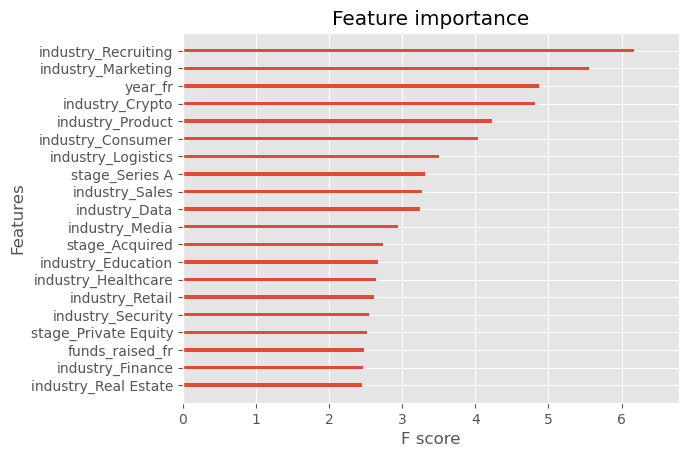

In [652]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

In [653]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train_processed, y_train)
y_hat_train = rf.predict(X_train_processed)
y_hat_test = rf.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9812206572769953
Testing Recall:  0.11392405063291139


Training F1:  0.9766355140186914
Testing F1:  0.16071428571428573


ROC AUC:  0.5225780711617278


Training Accuracy:  0.9921996879875195
Testing Accuracy:  0.780373831775701


In [654]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_hat_train = rf.predict(X_train_res)
y_hat_test = rf.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9887745556594949
Testing Recall:  0.27848101265822783


Training F1:  0.9938881053126469
Testing F1:  0.3308270676691729


ROC AUC:  0.5933952341228101


Training Accuracy:  0.9939195509822264
Testing Accuracy:  0.7920560747663551


In [655]:
# Logistic Regression with balanced class weight - big improvement
lr = LogisticRegression(random_state=42, class_weight='balanced') 

lr.fit(X_train_scaled, y_train)

y_hat_train = lr.predict(X_train_scaled)
y_hat_test = lr.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.6713615023474179
Testing Recall:  0.6835443037974683


Training F1:  0.40281690140845067
Testing F1:  0.4426229508196721


ROC AUC:  0.6827463639331182


Training Accuracy:  0.6692667706708268
Testing Accuracy:  0.6822429906542056


In [656]:
lr2 = LogisticRegression(random_state=42)
lr2.fit(X_train_res_scaled, y_train_res_scaled)

y_hat_train = lr2.predict(X_train_res_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.6594948550046773
Testing Recall:  0.7088607594936709


Training F1:  0.6707897240723121
Testing F1:  0.46861924686192474


ROC AUC:  0.7054332450763483


Training Accuracy:  0.676333021515435
Testing Accuracy:  0.7032710280373832


In [657]:
# param tuning logistic regression model
pipe = Pipeline([('classifier' , LogisticRegression(random_state=42))])

param_grid = [{
    
    'classifier' : [LogisticRegression(random_state=42)],
    'classifier__C': [0, 0.5, 1, 2, 1e12],
    'classifier__solver': ['newton-cg', 'liblinear', 'lbfgs', 'saga'],
    'classifier__penalty': ['l1', 'l2', None],
   
}]

lr_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

lr_best = lr_grid.fit(X_train_res_scaled, y_train_res_scaled)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

This model correctly identifies 61% of companies that had more than one round of layoffs (recall).
When it predicts a company had multiple layoffs, it is correct 41% of the time (precision).

In [658]:
y_hat_train = lr_best.predict(X_train_res_scaled) # or scaled
y_hat_test = lr_best.predict(X_test_scaled) # or scaled

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.666043030869972
Testing Recall:  0.7088607594936709


Training F1:  0.67233238904627
Testing F1:  0.459016393442623


ROC AUC:  0.6982699212941134


Training Accuracy:  0.6753975678203928
Testing Accuracy:  0.6915887850467289


In [659]:
lr_best.best_params_

{'classifier': LogisticRegression(C=0.5, penalty='l1', random_state=42, solver='liblinear'),
 'classifier__C': 0.5,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [660]:
best_lr = LogisticRegression(random_state=42, C=0.5, penalty='l1', solver='liblinear')
best_lr.fit(X_train_res_scaled, y_train_res_scaled)

LogisticRegression(C=0.5, penalty='l1', random_state=42, solver='liblinear')

In [661]:
## Top coefficients

coef_df = pd.DataFrame(best_lr.coef_, columns=X_train_res_scaled.columns).transpose()

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

,coef,coef_abs
industry_Recruiting,-2.345426,2.345426
stage_Series A,-1.555835,1.555835
industry_Real Estate,1.458090,1.458090
stage_Private Equity,-1.135442,1.135442
industry_Education,1.094913,1.094913
stage_Seed,-1.024950,1.024950
industry_Data,-0.940654,0.940654
stage_Acquired,-0.891482,0.891482
industry_HR,-0.878737,0.878737
industry_Infrastructure,-0.725138,0.725138


In [662]:
feat_importance = coef_df.sort_values(by='coef_abs', ascending=False)[:20]

y=np.array(feat_importance['coef'])
color=np.array(['rgb(255,255,255)']*y.shape[0])
color[y<0]='rgb(204,204, 205)'
color[y>=0]='rgb(130, 0, 0)'

data=[dict(type='bar',
       y=y,
       marker=dict(color=color.tolist()) 
      )]


fig = px.bar(feat_importance['coef'], color=data[0]['marker']['color'])
fig.show()

In [663]:
fig = px.bar(feat_importance['coef'])
fig.show()

In [664]:
### PREDICTION EXAMPLE ###
example_company = ['Austin', 'Stage B', 'Real Estate', 'United States', 50.0]

###  Classification with Crunchbase Data

In [666]:
df_class_final = df_classification_cb.drop(['Headquarters Regions', 'Founded Date'], axis=1)

In [667]:
df_class_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   company                                 1456 non-null   object 
 1   date                                    1456 non-null   object 
 2   industry                                1456 non-null   object 
 3   country                                 1456 non-null   object 
 4   Headquarters Location                   1456 non-null   object 
 5   Operating Status                        1456 non-null   object 
 6   total_laid_off                          1456 non-null   float64
 7   percentage_laid_off                     1456 non-null   float64
 8   stage                                   1454 non-null   object 
 9   Industries                              1456 non-null   object 
 10  Industry Groups                         1456 non-null   obje

In [668]:
df_class_final['multiple'] = [1 if co in mult_layoffs else 0 for co in df_class_final.company]

In [669]:
df_class_final = df_class_final[~df_class_final.duplicated()]

In [670]:
df2 = df_class_final.drop(['Estimated Revenue Range', 
                           'total_laid_off', 
                           'percentage_laid_off'], axis=1)

In [671]:
# dropping duplicates
df2 = df2[~df2.duplicated()]

In [672]:
# sorting from oldest to newest
df2 = df2.sort_values(by='date').reset_index(drop=True)

# dropping duplicated where stage is Unknown
dup = df2[df2.duplicated(subset='company')]
df2 = df2.drop(index=list(dup[dup['stage']=='Unknown'].index)).reset_index(drop=True)

# keeping rows with most recent record
df2 = df2.drop_duplicates(subset='company', keep='last').reset_index(drop=True)

In [673]:
df2.multiple.value_counts(normalize=True)

0    0.78
1    0.22
Name: multiple, dtype: float64

#### Train Test Split

In [674]:
X = df2.drop(['multiple', 'company', 'date'], axis=1)
y = df2['multiple']

In [675]:
X.head()

,industry,country,Headquarters Location,Operating Status,stage,Industries,Industry Groups,Total Funding Amount Currency (in USD),Number of Funding Rounds,Trend Score (30 Days),Number of Employees,Number of Acquisitions,year_fr,funds_raised_fr,founded_year,rev_est
0,Retail,United States,"New York, New York, United States",Active,Series C,"E-Commerce, Fashion, Lifestyle, Retail, Shoes,...","Clothing and Apparel, Commerce and Shopping, C...",90492915.0,3.0,1.0,1-10,0.0,2020,90.0,2010.0,5000000.0
1,Transportation,United States,"Los Angeles, California, United States",Active,Unknown,"Child Care, Children, Information Technology, ...","Community and Lifestyle, Health Care, Informat...",123799999.0,12.0,2.1,101-250,0.0,2020,45.0,2014.0,500000.0
2,Consumer,United States,"Bucharest, Bucuresti, Romania",Active,Seed,"Advertising, Event Management, Small and Mediu...","Advertising, Events, Media and Entertainment, ...",197000000.0,6.0,-0.5,1-10,0.0,2020,1.0,2016.0,500000.0
3,Support,United States,"Austin, Texas, United States",Active,Seed,"Customer Service, Enterprise Software, SaaS","Other, Professional Services, Software",6000000.0,1.0,0.6,11-50,0.0,2020,6.0,2021.0,5000000.0
4,Marketing,United States,"Boulder, Colorado, United States",Active,Seed,"Advertising, Advertising Platforms","Advertising, Sales and Marketing",4618000.0,5.0,0.6,11-50,0.0,2020,4.0,2012.0,5000000.0


In [676]:
# train test split & preprocess
cat_columns = ['industry', 'stage', 'Number of Employees', 
               'Operating Status', 'country']

X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [677]:
print(y_train.value_counts())

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

print(pd.Series(y_train_res).value_counts()) 

0    638
1    187
Name: multiple, dtype: int64
0    638
1    638
Name: multiple, dtype: int64


#### Logistic Regression

In [678]:
lr2 = LogisticRegression(random_state=42, solver='liblinear')
lr2.fit(X_train_res_scaled, y_train_res_scaled)

y_hat_train = lr2.predict(X_train_res_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7664576802507836
Testing Recall:  0.6363636363636364


Training F1:  0.7599067599067598
Testing F1:  0.40229885057471265


ROC AUC:  0.6272727272727272


Training Accuracy:  0.7578369905956113
Testing Accuracy:  0.6218181818181818


In [679]:
## Top coefficients - this list makes a lot of sense

coef_df = pd.DataFrame(lr2.coef_, columns=X_train_res_scaled.columns).transpose()
#coef_df.to_csv('coef_logreg.csv')

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

,coef,coef_abs
industry_Aerospace,1.769222,1.769222
country_Indonesia,-1.624918,1.624918
country_Romania,1.416703,1.416703
Number of Employees_11-50,-1.413407,1.413407
industry_Recruiting,-1.388256,1.388256
industry_Crypto,1.314073,1.314073
industry_HR,-1.183329,1.183329
country_Kenya,1.092256,1.092256
country_Norway,1.042012,1.042012
Number of Employees_1-10,-1.016421,1.016421


In [680]:
# param tuning logistic regression model
pipe = Pipeline([('classifier' , LogisticRegression(random_state=42))])

param_grid = [{
    
    'classifier' : [LogisticRegression(random_state=42)],
    'classifier__C': [0, 0.5, 1, 2, 1e12],
    'classifier__solver': ['newton-cg', 'liblinear', 'lbfgs', 'saga'],
    'classifier__penalty': ['l1', 'l2', None],
   
}]

lr_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

lr_best = lr_grid.fit(X_train_res_scaled, y_train_res_scaled)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/cap-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

In [681]:
lr_best.best_params_

{'classifier': LogisticRegression(C=1000000000000.0, penalty='l1', random_state=42,
                    solver='liblinear'),
 'classifier__C': 1000000000000.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [682]:
y_hat_train = lr_best.predict(X_train_res_scaled) # or scaled
y_hat_test = lr_best.predict(X_test_scaled) # or scaled

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7695924764890282
Testing Recall:  0.6545454545454545


Training F1:  0.765990639625585
Testing F1:  0.4210526315789474


ROC AUC:  0.6454545454545454


Training Accuracy:  0.7648902821316614
Testing Accuracy:  0.64


In [683]:
lr3 = LogisticRegression(random_state=42, class_weight='balanced')
lr3.fit(X_train_scaled, y_train)

y_hat_train = lr2.predict(X_train_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7272727272727273
Testing Recall:  0.6363636363636364


Training F1:  0.5631469979296067
Testing F1:  0.40229885057471265


ROC AUC:  0.6272727272727272


Training Accuracy:  0.7442424242424243
Testing Accuracy:  0.6218181818181818


In [684]:
X_train_processed.head()

,industry_Aerospace,industry_Construction,industry_Consumer,industry_Crypto,industry_Data,industry_Education,industry_Energy,industry_Finance,industry_Fitness,industry_Food,...,country_United Kingdom,country_United States,Total Funding Amount Currency (in USD),Number of Funding Rounds,Trend Score (30 Days),Number of Acquisitions,year_fr,funds_raised_fr,founded_year,rev_est
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,170000000.0,4.0,9.2,0.0,2020,20.0,1995.0,300000000.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,197000000.0,6.0,6.4,0.0,2022,148.0,2021.0,5000000.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,55000000.0,2.0,-0.1,0.0,2020,55.0,2003.0,75000000.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,30000000.0,5.0,-0.4,0.0,2022,30.0,2015.0,30000000.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,114800000.0,7.0,-0.2,1.0,2020,114.0,2010.0,30000000.0


In [728]:
lr3 = LogisticRegression(random_state=42, class_weight='balanced')
lr3.fit(X_train_scaled, y_train)

y_hat_train = lr3.predict(X_train_scaled)
y_hat_test = lr3.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8770053475935828
Testing Recall:  0.5636363636363636


Training F1:  0.7272727272727273
Testing F1:  0.4275862068965517


ROC AUC:  0.6477272727272727


Training Accuracy:  0.850909090909091
Testing Accuracy:  0.6981818181818182


In [729]:
lr4 = LogisticRegression(random_state=42, penalty='l2', C=1e12)
lr4.fit(X_train_res_scaled, y_train_res)

y_hat_train = lr3.predict(X_train_res_scaled)
y_hat_test = lr3.predict(X_test_scaled)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8934169278996865
Testing Recall:  0.5636363636363636


Training F1:  0.8715596330275228
Testing F1:  0.4275862068965517


ROC AUC:  0.6477272727272727


Training Accuracy:  0.8683385579937304
Testing Accuracy:  0.6981818181818182


#### XG Boost Classifier

In [685]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=2, 
                    min_child_weight=30, subsample=0.5)
xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8609625668449198
Testing Recall:  0.6909090909090909


Training F1:  0.5750000000000001
Testing F1:  0.4342857142857143


ROC AUC:  0.6590909090909091


Training Accuracy:  0.7115151515151515
Testing Accuracy:  0.64


In [734]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   industry                                1100 non-null   object 
 1   country                                 1100 non-null   object 
 2   Headquarters Location                   1100 non-null   object 
 3   Operating Status                        1100 non-null   object 
 4   stage                                   1098 non-null   object 
 5   Industries                              1100 non-null   object 
 6   Industry Groups                         1100 non-null   object 
 7   Total Funding Amount Currency (in USD)  1100 non-null   float64
 8   Number of Funding Rounds                1100 non-null   float64
 9   Trend Score (30 Days)                   1100 non-null   float64
 10  Number of Employees                     1100 non-null   obje

In [732]:
## uncomment to add more specific features (location and industry group)

# # train test split & preprocess
# cat_columns = ['industry', 'stage', 'Number of Employees', 
#                'Operating Status', 'country'] #'location' #industry groups

# X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
# y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [727]:
# print(y_train.value_counts())

# sm = SMOTE(random_state = 42)
# X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
# X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

# print(pd.Series(y_train_res).value_counts()) 

0    638
1    187
Name: multiple, dtype: int64
0    638
1    638
Name: multiple, dtype: int64


In [733]:
X_train_processed.columns

Index(['industry_Aerospace', 'industry_Construction', 'industry_Consumer',
       'industry_Crypto', 'industry_Data', 'industry_Education',
       'industry_Energy', 'industry_Finance', 'industry_Fitness',
       'industry_Food',
       ...
       'country_United Kingdom', 'country_United States',
       'Total Funding Amount Currency (in USD)', 'Number of Funding Rounds',
       'Trend Score (30 Days)', 'Number of Acquisitions', 'year_fr',
       'funds_raised_fr', 'founded_year', 'rev_est'],
      dtype='object', length=104)

In [730]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=2, 
                     min_child_weight=10, subsample=0.5) # with full data

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9090909090909091
Testing Recall:  0.6363636363636364


Training F1:  0.6215722120658135
Testing F1:  0.39772727272727265


ROC AUC:  0.6227272727272727


Training Accuracy:  0.7490909090909091
Testing Accuracy:  0.6145454545454545


In [691]:
xgb = XGBClassifier(random_state=42, max_depth=4, min_child_weight=25, 
                    subsample=0.5) # country / industry
xgb.fit(X_train_res, y_train_res)
y_hat_train = xgb.predict(X_train_res)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8213166144200627
Testing Recall:  0.45454545454545453


Training F1:  0.8478964401294499
Testing F1:  0.43103448275862066


ROC AUC:  0.6454545454545455


Training Accuracy:  0.8526645768025078
Testing Accuracy:  0.76


In [692]:
### BEST MODEL ###

In [750]:
# best with indstry / country
X_train_processed = X_train_processed.reindex(sorted(X_train_processed.columns), axis=1)
X_test_processed = X_test_processed.reindex(sorted(X_test_processed.columns), axis=1)

xgb = XGBClassifier(random_state=42, scale_pos_weight=4, max_depth=2, 
                     min_child_weight=50, subsample=0.5) # with full data / smote

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7700534759358288
Testing Recall:  0.7454545454545455


Training F1:  0.5236363636363636
Testing F1:  0.44324324324324327


ROC AUC:  0.6704545454545454


Training Accuracy:  0.6824242424242424
Testing Accuracy:  0.6254545454545455


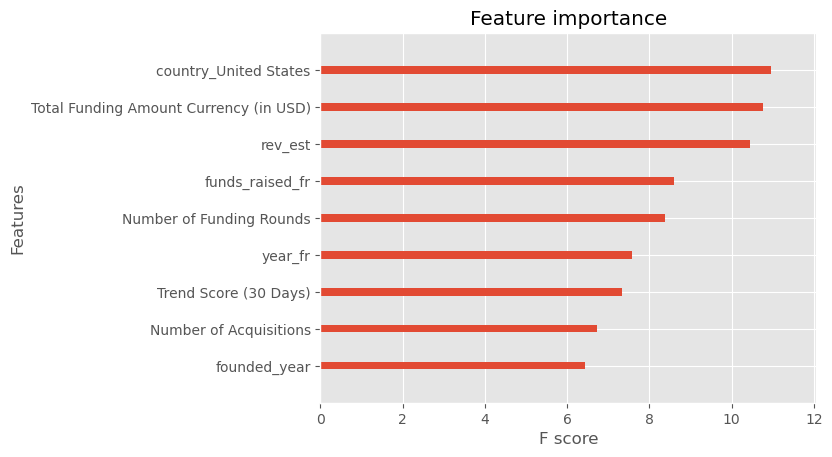

In [745]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

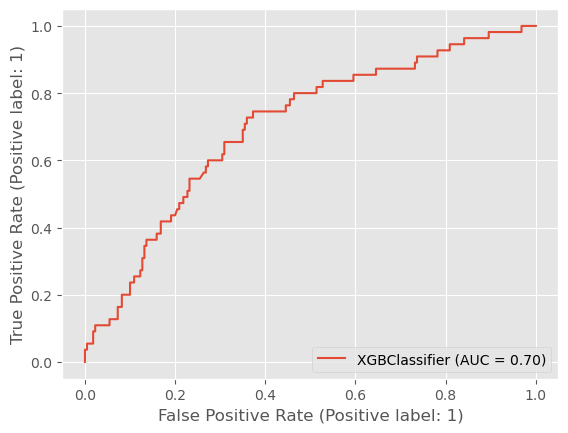

In [751]:
# plot ROC AUC
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb, X_test_processed, y_test) 

plt.savefig('assets/ROC_AUC_curve.png')

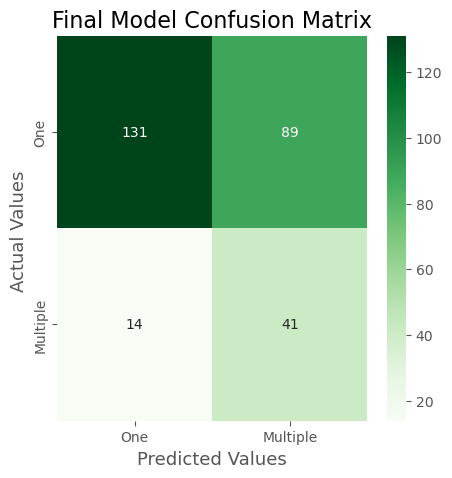

In [752]:
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)
fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Final Model Confusion Matrix', fontsize=16);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

ax.xaxis.set_ticklabels(['One','Multiple'])
ax.yaxis.set_ticklabels(['One','Multiple'])

##
plt.savefig('assets/final_confusion_matrix.png')

## Display the visualization of the Confusion Matrix.
plt.show()

In [697]:
# save final model for use in dashboard
filename = 'final_classification_model.pkl'
pickle.dump(xgb, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_processed, y_test)

print(result)

0.64


In [698]:
pred_df = pd.DataFrame(columns=X_train_processed.columns)
pred_df

X.columns

example_co = ['Aerospace', 'United Kingdom', 10000000, 3, 0.5, '1000', 2, 2021, 320, 2018, 50000000]

def prep_pred(example_co):
    example_df = pd.DataFrame(columns=X.columns[-11:])
    #example_co = ['Aerospace', 'United Kingdom', 10000000, 3, 0.5, 2, 2021, 320, 2018, 50000000]
    ex = example_co
    ex[0] = 'industry_'+ example_co[0]
    ex[1] = 'country_'+ example_co[1]
    ex[5] = 'Number of Employees_'+ example_co[5]
    example_df.rename(columns={'Industries': ex[0], 
                               'Industry Groups': ex[1], 
                               'Number of Employees': ex[5]}, inplace=True)
    
    ex[0] = 1
    ex[1] = 1
    ex[5] = 1
   
    example_df.loc[0] = ex
    
    for col in X_train_processed:
        if col not in example_df:
            #print("Adding missing feature {}".format(col))
            example_df[col] = 0
            
    example_df = example_df.reindex(sorted(example_df.columns), axis=1)

    return example_df

In [699]:
example_co = ['Marketing', 'United Kingdom', 10000000, 3, 0.5, '501-1000', 2, 2021, 10, 2018, 50000000]
test = prep_pred(example_co)
#test = test.reindex(sorted(test.columns), axis=1)
loaded_model.predict(test)

Adding missing feature Number of Employees_1-10
Adding missing feature Number of Employees_10001+
Adding missing feature Number of Employees_1001-5000
Adding missing feature Number of Employees_101-250
Adding missing feature Number of Employees_11-50
Adding missing feature Number of Employees_251-500
Adding missing feature Number of Employees_5001-10000
Adding missing feature Number of Employees_51-100
Adding missing feature Operating Status_Active
Adding missing feature Operating Status_Closed
Adding missing feature country_Argentina
Adding missing feature country_Australia
Adding missing feature country_Austria
Adding missing feature country_Brazil
Adding missing feature country_Canada
Adding missing feature country_Chile
Adding missing feature country_China
Adding missing feature country_Colombia
Adding missing feature country_Denmark
Adding missing feature country_Egypt
Adding missing feature country_Estonia
Adding missing feature country_France
Adding missing feature country_Germa

array([0])

In [700]:
for col_name in test.columns:
    
    if col_name not in X_train_processed.columns:
        print('Error! ', col_name)

In [760]:
# BEST MODEL
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=4, 
                     min_child_weight=30, subsample=0.5) # with full data / smote

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8770053475935828
Testing Recall:  0.6909090909090909


Training F1:  0.592057761732852
Testing F1:  0.44186046511627913


ROC AUC:  0.6659090909090909


Training Accuracy:  0.7260606060606061
Testing Accuracy:  0.6509090909090909


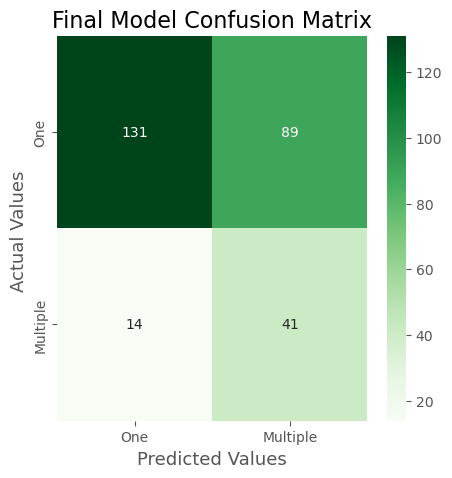

In [764]:
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)
fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Final Model Confusion Matrix', fontsize=16);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

ax.xaxis.set_ticklabels(['One','Multiple'])
ax.yaxis.set_ticklabels(['One','Multiple'])

##
plt.savefig('assets/final_confusion_matrix.png')

## Display the visualization of the Confusion Matrix.
plt.show()

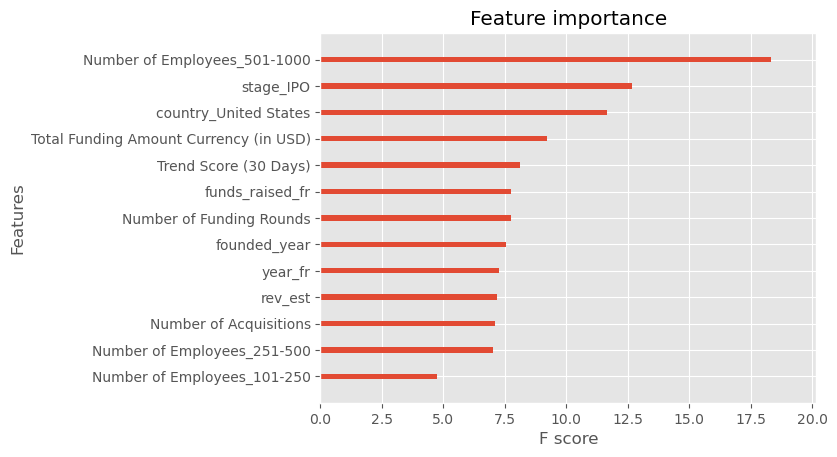

In [761]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

In [762]:
# witn industry rather than industry group
xgb = XGBClassifier(random_state=42, scale_pos_weight=4, max_depth=2, 
                    min_child_weight=50, subsample=0.5)


xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7700534759358288
Testing Recall:  0.7454545454545455


Training F1:  0.5236363636363636
Testing F1:  0.44324324324324327


ROC AUC:  0.6704545454545454


Training Accuracy:  0.6824242424242424
Testing Accuracy:  0.6254545454545455


In [704]:
pred_df

,Number of Acquisitions,Number of Employees_1-10,Number of Employees_10001+,Number of Employees_1001-5000,Number of Employees_101-250,Number of Employees_11-50,Number of Employees_251-500,Number of Employees_5001-10000,Number of Employees_501-1000,Number of Employees_51-100,...,stage_Series E,stage_Series F,stage_Series G,stage_Series H,stage_Series I,stage_Series J,stage_Subsidiary,stage_Unknown,stage_nan,year_fr


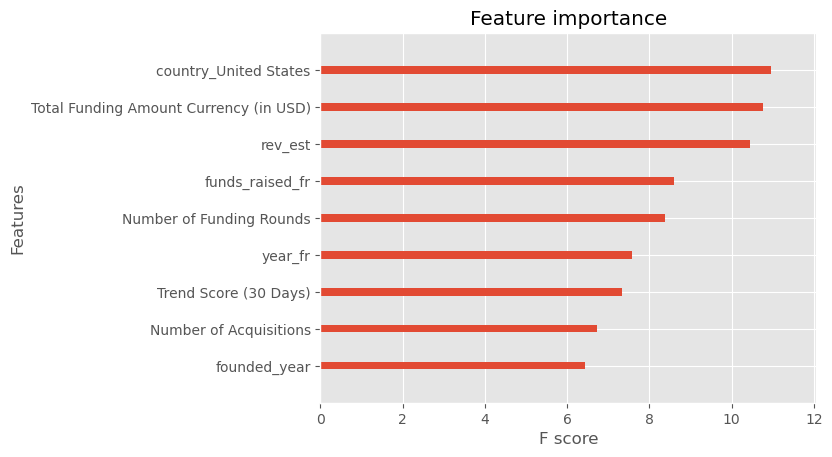

In [763]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

## APPENDIX

When you are modeling for prediction, you are asking the question "How well can I use X (independent variables or features) to predict Y (dependent or target or outcome variable)?" Thus, in this case, you are less concerned about how and which features impact Y as opposed to how you can efficiently use them to predict Y.

When modeling for prediction, you typically use all available features (and most likely engineer new features) because you are trying to accurately predict Y, at all costs. As a result, you are less concerned about the coefficients of these features and instead focus on the overall accuracy of the model.

target = layoffs 
inputs:
- sector
- econ data
- job postings by sector?
- business openings?
- some measure of revenues

Regression for each sector?

Classification - given one layoff, prob of second?

In [707]:
# xgb = XGBClassifier(random_state=42, max_depth=3,  
#                     min_child_weight=30, subsample=0.5, alpha=0.5)


# xgb.fit(X_train_res, y_train_res)
# y_hat_train = xgb.predict(X_train_res)
# y_hat_test = xgb.predict(X_test_processed)

# print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

In [708]:
# plot_importance(xgb, max_num_features=20, importance_type='gain', 
#                 show_values=False)
# plt.show()